In [2]:
from PIL import Image
import pyFAI, fabio
from pyFAI.gui import jupyter
import pyFAI
import os
import matplotlib.pyplot as plt
os.chdir(r'/blue/mbutala/dalverson/SimDAT2D/SimDAT2D/SimDAT2D')

#Tiff file you want to be integrated
sc_img = fabio.open("Xtalline_GST_SC_avg_im.tiff").data


fs_img = fabio.open("Xtalline_GST_FS_avg_im.tiff").data

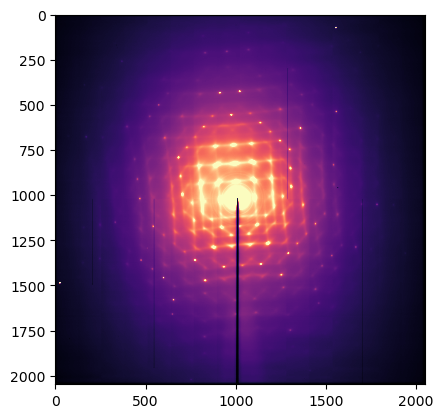

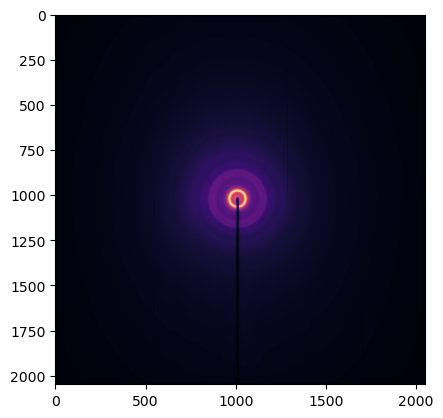

In [3]:
plt.figure()
plt.imshow(sc_img, cmap= 'magma', vmin = 5, vmax = 100)

plt.figure()
plt.imshow(fs_img, cmap= 'magma')

In [65]:
import IsoDAT2D as iso
import SimDAT2D as sim
import dask.array as da
import dask.dataframe as dd
import masking
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pyFAI
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator

def image_rotation(image, angle, show = False):
    """
    This function rotates the combined image by a user specified angle amount, if the angle specified is 1, the result is that the combined image is rotated by one degree.
    
    Parameters:
        image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        """
    pil_format = Image.fromarray(image)
    rotated_image = pil_format.rotate(angle)
    rotated_image = np.array(rotated_image)
    
    if show == True:
        #display the rotated image
        plt.figure(figsize=(10, 10))
        plt.imshow(rotated_image, cmap='viridis')
        plt.title("Rotated Image")
        plt.show()
    return rotated_image

#Create a function that takes the combined image and integrates it using the azimuthal integrator and displays the 1D image
def integrate_image(combined_image, distance, wavelength, resolution = 3000, mask = None, show = False, radial_range = None):
    """
    This function integrates the combined image using the azimuthal integrator and displays the 1D image.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
    """
    #initialize the azimuthal integrator
    
     # Initialize the detector
    dete = pyFAI.detectors.Perkin()
    p1, p2, p3 = dete.calc_cartesian_positions()
    poni1 = p1.mean()
    poni2 = p2.mean()
    
    
    ai = AzimuthalIntegrator(dist=distance, poni1=poni1, poni2=poni2, detector=dete, wavelength=wavelength)
    
    #integrate the combined image using the azimuthal integrator
    q, I = ai.integrate1d(combined_image, resolution, radial_range = radial_range, unit = 'q_A^-1', mask = mask)
    
    if show == True:
        #plot the 1D image
        plt.figure(figsize=(10, 10))
        plt.plot(q, I)
        plt.title("1D X-Ray Diffraction Image")
        plt.show()
    
    return q, I
    

def rotate_and_integrate(combined_image, angle_of_rotation, distance, wavelength, resolution = 1000, mask = None):
    """
    This function takes the combined image, the mask, the distance, the wavelength, and the resolution of integration, and rotates the combined image by a user specified angle amount, if the angle specified is 1, the result will be 360 integrations of the combined image, each integration will be rotated by 1 degree.
    
    Parameters:
        combined_image (2D array): The image of the combined spots and calibration.
        angle_of_rotation (int): The angle of rotation.
        distance (float): The distance from the detector to the sample.
        wavelength (float): The wavelength of the x-rays.
        resolution (int): The resolution of the integration.
        mask (2D array): The mask to use for the integration.
    """
    
    import pandas as pd 
    
    #create a dataframe to store the 1D integrations
    df = pd.DataFrame()
    
    #create a loop that rotates the combined image by the user specified angle amount and integrates the image
    for i in range(0, 360, angle_of_rotation):
        #rotate the mask for the combined image
        rotated_image = image_rotation(combined_image, i);
    
        
        #integrate the rotated image
        q, I = integrate_image(rotated_image, distance, wavelength, resolution, mask, show = False, radial_range = (0, 25));
        
        #add the 1D integration to the dataframe
        df[i] = I
        
        #create a waterfall plot of the 1D integrations, where each dataset is moved up on the y axis by a multiple of .5
    plt.figure(figsize=(10, 10))
    for j in range(0, 360, angle_of_rotation):
            plt.plot(q, (df[j]+ j*.01), alpha = .55, c = 'black')
    plt.xlabel('q A $^(-1)$')
    plt.ylabel('Intensity')
    plt.title("Waterfall Plot of Rotated 1D X-Ray Diffraction Images")
    plt.show()        
    return q, df

def make_masks(array, slices):
    masks = []
    for i in slices:
        masks.append(masking.generate_mask_slices(array, .5, i, offset = 7))
        print('Mask with {} slices created'.format(i))
    return masks

def generate_mask_slices(array, width, num_slices, offset = 5):
    
    ''' Returns a mask with multiple slices of the chi array left unmasked to be used for integration.
    
    Keyword arguments:
    chi_array -- chi array
    width -- width of the slice in degrees
    num_slices -- number of slices
    offset -- offset between slices in degrees
    plot -- if True, plots the mask (default False)
    
    '''
    mask_list = []
    
    # Create masks for the positive values
    for i in range(num_slices):
        start = i * (width + offset)
        end = start + width
        mask_list.append(ma.masked_inside(array, start, end))

    # Create masks for the negative values
    for i in range(num_slices):
        start = - (i + 1) * (width + offset)
        end = start - width
        mask_list.append(ma.masked_inside(array, start, end))
    
    #add all genrated masks together
    
    print(mask_list)

    combined_mask = mask_list[0]
    for mask in mask_list[1:]:
        combined_mask += mask
        
    inverted_mask = ~combined_mask.mask 
    plt.figure()
    plt.imshow(~combined_mask.mask)
    
    return inverted_mask

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

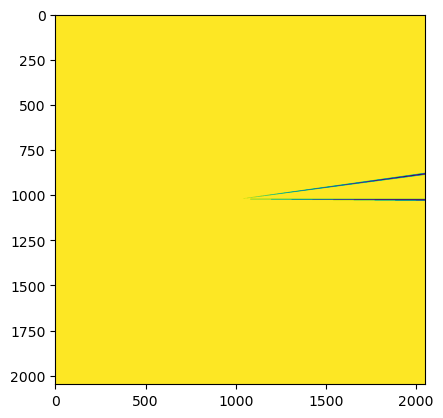

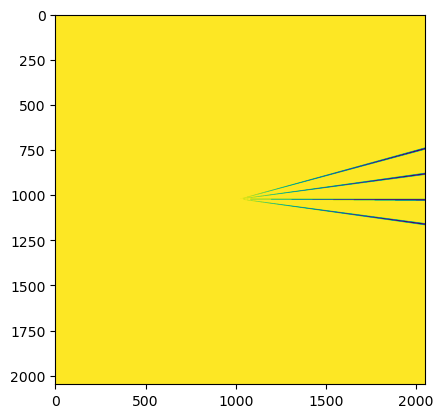

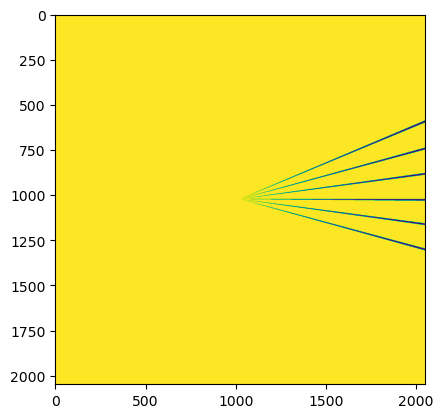

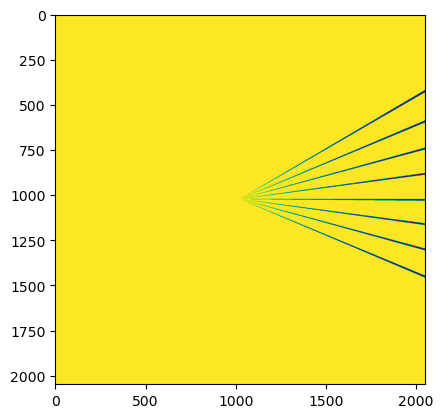

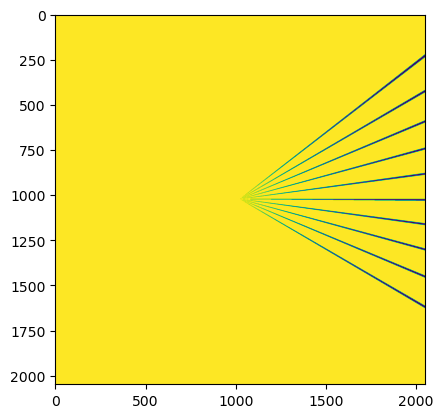

In [5]:
array, ai_pe = masking.make_chi_array(sc_img, .4, .4e-10)
#pure = sim.create_isotropic(.4, .4e-10, cmap = 'magma')
masks = make_masks(array, [1,2,3, 4, 5])
mask_one = masks[0]
mask_two = masks[1]
mask_three = masks[2]
mask_four = masks[3]
mask_five = masks[4]

[masked_array(
  data=[[-135.00017100451313, -134.97216689027152, -134.94413749056966,
         ..., -45.05619265132289, -45.02816084175853, -45.00015640746067],
        [-135.02817528583523, -135.0001711717571, -134.97214174542282,
         ..., -45.02818839694317, -45.00015656042945, -44.97215212598207],
        [-135.05620485260465, -135.02820076548636, -135.000171339316,
         ..., -45.00015880320792, -44.972126966543236,
         -44.94412255874272],
        ...,
        [135.0561923155709, 135.02818822843457, 135.00015880225814, ...,
         45.00017134026579, 44.97213950359518, 44.94413509577675],
        [135.0281606735792, 135.000156559494, 134.9721271331666, ...,
         45.028203009199196, 45.00017117269255, 44.972166738238265],
        [135.00015640652705, 134.97215229229232, 134.94412289261135, ...,
         45.05620724928089, 45.028175439737566, 45.00017100544677]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

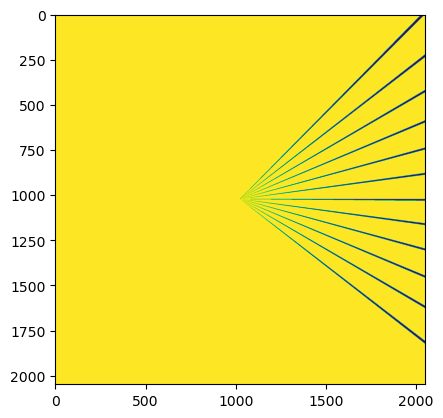

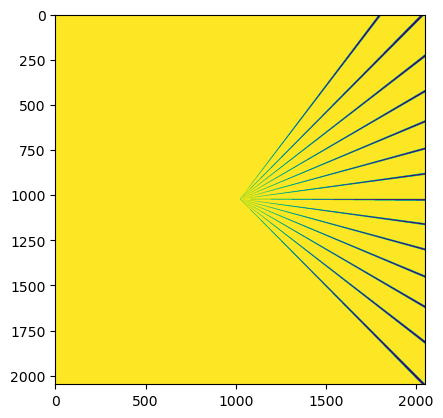

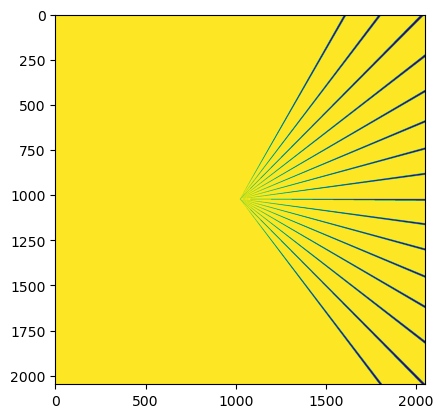

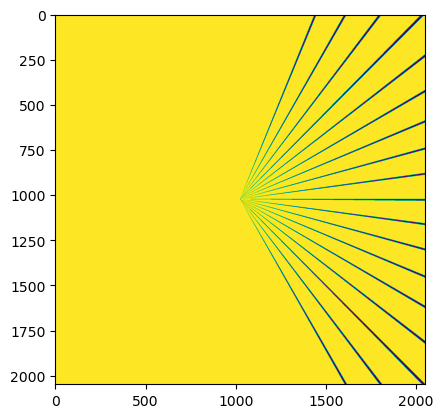

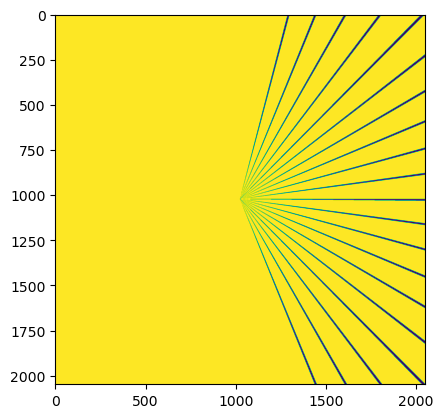

In [462]:
more_masks = make_masks(array, [6, 7, 8, 9, 10])
mask_six = more_masks[0]
mask_seven = more_masks[1]
mask_eight = more_masks[2]
mask_nine = more_masks[3]
mask_ten = more_masks[4]

/scratch/local/25202707/ipykernel_3976856/1585325071.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


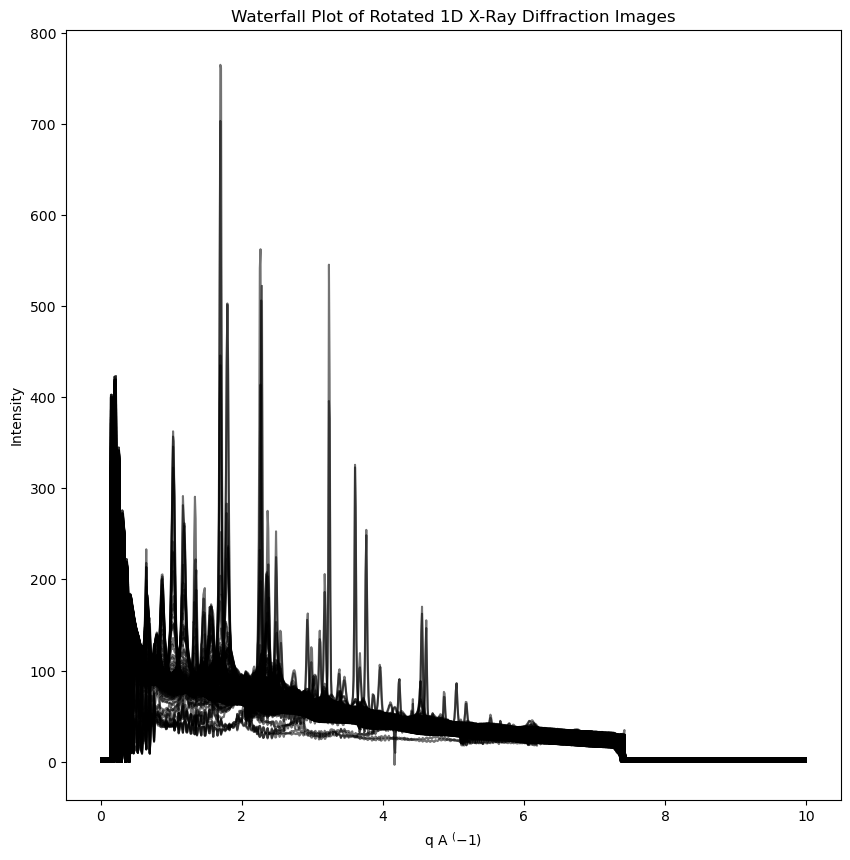

/scratch/local/25202707/ipykernel_3976856/1585325071.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


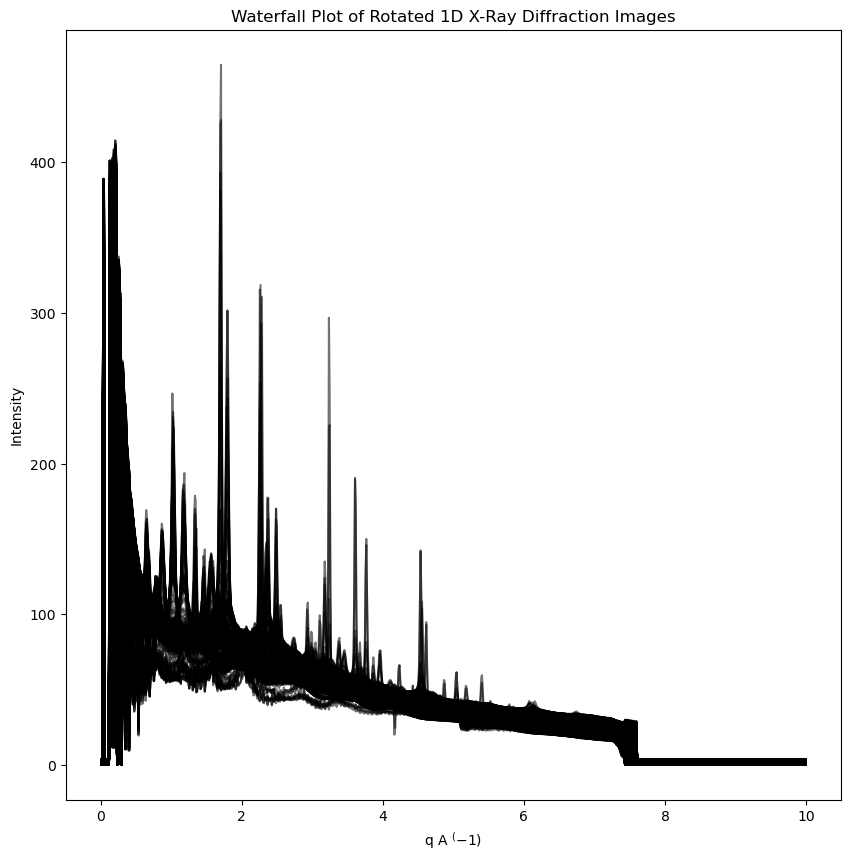

/scratch/local/25202707/ipykernel_3976856/1585325071.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


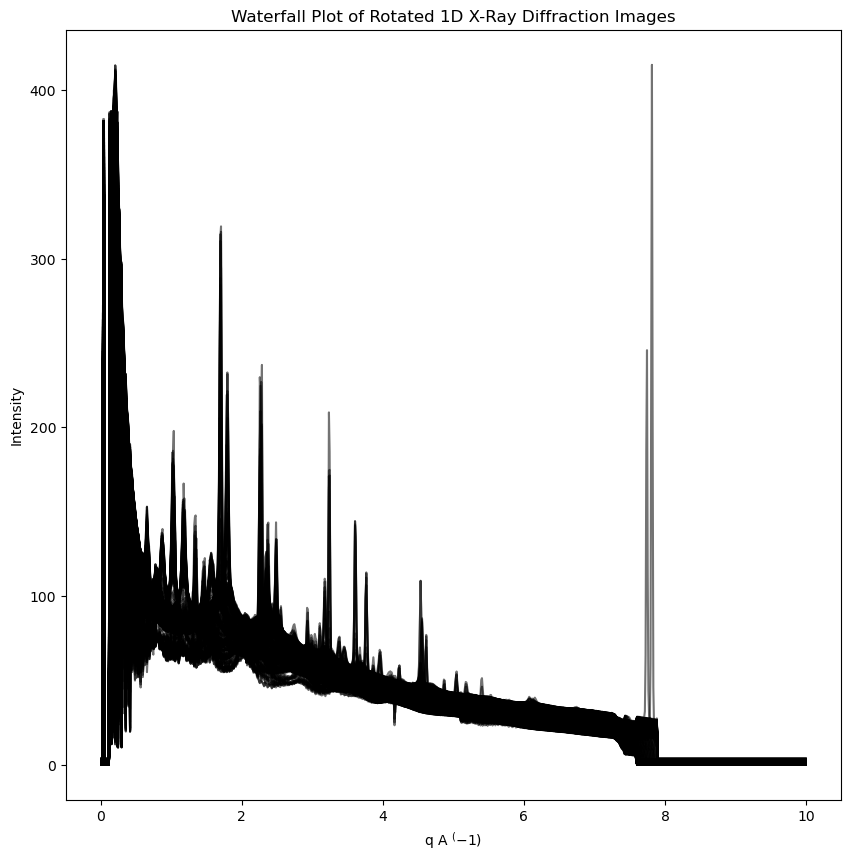

/scratch/local/25202707/ipykernel_3976856/1585325071.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


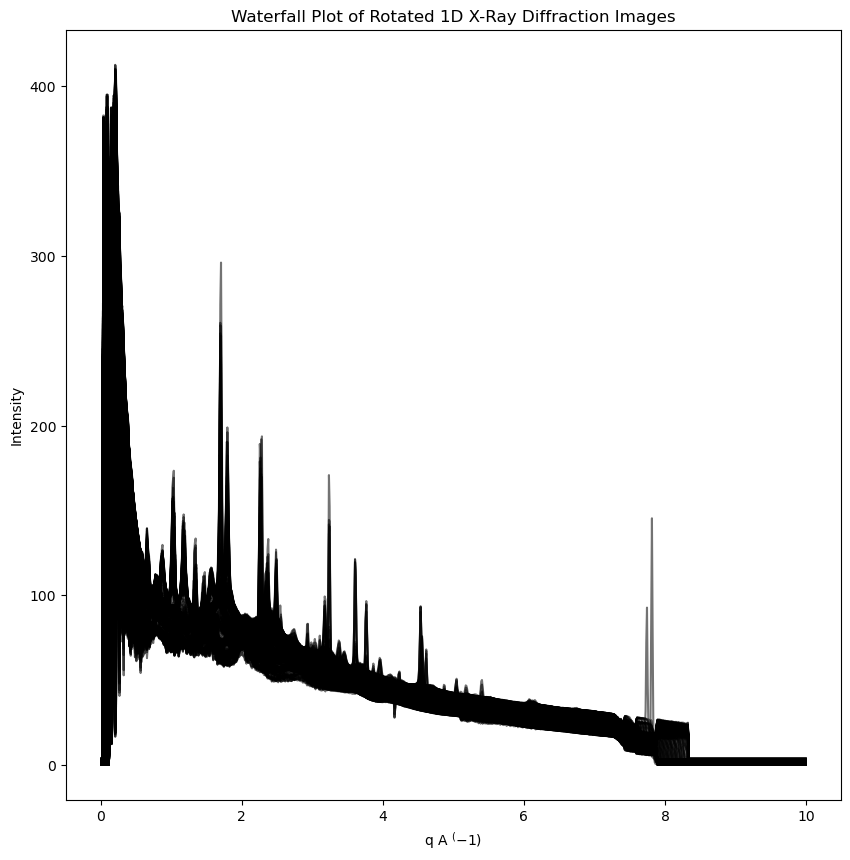

/scratch/local/25202707/ipykernel_3976856/1585325071.py:92: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[i] = I


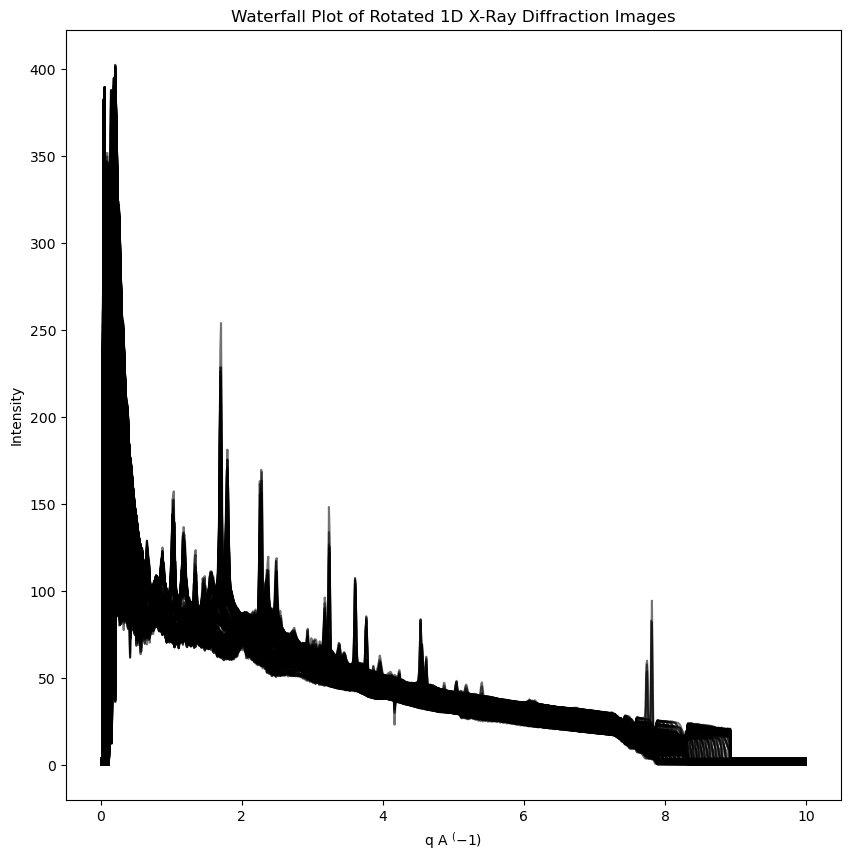

In [6]:
q, ints = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_one)
q, ints1 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_two)
q, ints2 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_three)
q, ints3 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_four)
q, ints4 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_five)

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import csv
import glob as glob
from tifffile import imread, imshow

def read_index_data_smart(filename,
                          junk=None, backjunk=None,
                          splitchar=None, do_not_float=False, 
                          shh=True, use_idex=[0,1]):
    
    """ A general 2-column data reader that attempts to 'smartly' skip metadata.
    The to-be-skipped metadata can be specified as 'junk' and 'backjunk', corresponding
    to the number of beginning and ending lines to skip. 
    'splitchar' specifies the character used to seperate columns.
    do_not_float is a bool (default False) to keep data as strings instead of convert to float.
    shh is a bool (default True) to supress certain debugging print statements.
    use_idex (a list) specifies which columns to return (default 0th and 1st). """
    
    with open(filename,'r') as infile:
        datain = infile.readlines()
    
    if junk == None:
        for i in range(len(datain)):
            try:
                for j in range(10):
                    x1,y1 = float(datain[i+j].split(splitchar)[use_idex[0]]), float(datain[i+j].split(splitchar)[use_idex[1]])
                junk = i
                break
            except:
                pass 
                
    if backjunk == None:
        for i in range(len(datain),-1,-1):
            try:
                x1,y1 = float(datain[i].split(splitchar)[use_idex[0]]), float(datain[i].split(splitchar)[use_idex[1]])
                backjunk = len(datain)-i-1
                break
            except:
                pass

    if backjunk == 0:
        datain = datain[junk:]
    else:
        datain = datain[junk:-backjunk]
    
    xin = np.zeros(len(datain))
    yin = np.zeros(len(datain))
    
    if do_not_float:
        xin = []
        yin = []
    
    if shh == False:
        print ('length '+str(len(xin)))
    if do_not_float:
        if splitchar==None:
            for i in range(len(datain)):
                xin.append(datain[i].split()[use_idex[0]])
                yin.append(datain[i].split()[use_idex[1]])
        else:
            for i in range(len(datain)):
                xin.append(datain[i].split(splitchar)[use_idex[0]])
                yin.append(datain[i].split(splitchar)[use_idex[1]])    
    else:        
        if splitchar==None:
            for i in range(len(datain)):
                xin[i]= float(datain[i].split()[use_idex[0]])
                yin[i]= float(datain[i].split()[use_idex[1]])
        else:
            for i in range(len(datain)):
                xin[i]= float(datain[i].split(splitchar)[use_idex[0]])
                yin[i]= float(datain[i].split(splitchar)[use_idex[1]])   
        
    return xin,yin    

def write_out_file(filename,x,y):
    """ write out a two-column dataset (x,y) with file named 'filename'"""
    outf = open(filename,'w')
    for i in range(len(x)):
        outf.write(str(x[i])+' '+str(y[i])+'\n')
    outf.close()

def read_all_into_list(file_list):
    #read the first file
    x,y = read_index_data_smart(file_list[0])
    my_df = pd.DataFrame(index=x)
    my_df[0] = y
    for i in range(1,len(file_list)):
        x,y = read_index_data_smart(file_list[i])
        my_df[i] = y
    return my_df

In [144]:
import glob
os.chdir(r'/blue/mbutala/dalverson/SimDAT2D/SimDAT2D/SimDAT2D')
file_list = sorted(glob.glob('Thin_Film_Signal_from_FS.xy'))
real_ish = read_all_into_list(file_list)

real_ish_pd = pd.DataFrame(real_ish)

q_for_real = real_ish_pd.index

In [13]:
column_mapping = {}
for i in range(361, 721):
    column_mapping[(i - 361)] = (i)

ints1.rename(columns=column_mapping, inplace=True) 
   
column_mapping = {}
for i in range(722, 1082):
    column_mapping[(i - 722)] = (i)
print(column_mapping)

ints2.rename(columns=column_mapping, inplace=True) 
column_mapping = {}
for i in range(1083, 1443):
    column_mapping[(i - 1083)] = (i)
print(column_mapping)

ints3.rename(columns=column_mapping, inplace=True)    
column_mapping = {}
for i in range(1444, 1804):
    column_mapping[(i - 1444)] = (i)
    
ints4.rename(columns=column_mapping, inplace=True)  

{0: 722, 1: 723, 2: 724, 3: 725, 4: 726, 5: 727, 6: 728, 7: 729, 8: 730, 9: 731, 10: 732, 11: 733, 12: 734, 13: 735, 14: 736, 15: 737, 16: 738, 17: 739, 18: 740, 19: 741, 20: 742, 21: 743, 22: 744, 23: 745, 24: 746, 25: 747, 26: 748, 27: 749, 28: 750, 29: 751, 30: 752, 31: 753, 32: 754, 33: 755, 34: 756, 35: 757, 36: 758, 37: 759, 38: 760, 39: 761, 40: 762, 41: 763, 42: 764, 43: 765, 44: 766, 45: 767, 46: 768, 47: 769, 48: 770, 49: 771, 50: 772, 51: 773, 52: 774, 53: 775, 54: 776, 55: 777, 56: 778, 57: 779, 58: 780, 59: 781, 60: 782, 61: 783, 62: 784, 63: 785, 64: 786, 65: 787, 66: 788, 67: 789, 68: 790, 69: 791, 70: 792, 71: 793, 72: 794, 73: 795, 74: 796, 75: 797, 76: 798, 77: 799, 78: 800, 79: 801, 80: 802, 81: 803, 82: 804, 83: 805, 84: 806, 85: 807, 86: 808, 87: 809, 88: 810, 89: 811, 90: 812, 91: 813, 92: 814, 93: 815, 94: 816, 95: 817, 96: 818, 97: 819, 98: 820, 99: 821, 100: 822, 101: 823, 102: 824, 103: 825, 104: 826, 105: 827, 106: 828, 107: 829, 108: 830, 109: 831, 110: 832,

In [15]:
data_v = pd.concat([ints, ints1, ints2, ints3, ints4], axis = 1)
data_v

0     1     2     3     4     5     6     7     8     9     ...  \
0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
1     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
996   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
997   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
998   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
999   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

           1794        1795        1796        1797        1798        1799  \
0      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
2      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
3    333.498627  333.498627  333.498627  325.004608  326.069031  326.059113   
4    323.643555  323.643555  323.643555  319.652863  320.152954  320.131042   
..          ...         ...         ...         ...         ...         ...   
995    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
996    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
997    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
998    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
999    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   

           1800        1801        1802        1803  
0      0.000000    0.000000    0.000000    0.000000  
1      0.000000    0.000000    0.000000    0.000000  
2      0.000000    0.000000    0.000000    0.000000  
3    326.059113  326.059113  326.059113  326.059113  
4    320.131042  320.131042  320.131042  320.131042  
..          ...         ...         ...         ...  
995    0.000000    0.000000    0.000000    0.000000  
996    0.000000    0.000000    0.000000    0.000000  
997    0.000000    0.000000    0.000000    0.000000  
998    0.000000    0.000000    0.000000    0.000000  
999    0.000000    0.000000    0.000000    0.000000  

[1000 rows x 1800 columns]

In [16]:
import IsoDAT2D as iso
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SimDAT2D as sim
import os
import IsoDAT2D as iso
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.decomposition import NMF
import dask
import glob as glob
from tifffile import imread, imshow
import warnings
import dask
import pickle 
from dask.distributed import Client, as_completed, get_worker

#data = pd.read_csv('integrations_more.csv')

def attempt(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q

def attempt2(Real_Data, Length, i, init= None, solver = 'cd', beta_loss = 'frobenius', iter = 500):
    NMF_model = NMF(n_components=i, init = init, solver = solver, beta_loss = beta_loss, max_iter = iter)
    NMF_data= NMF_model.fit_transform(Real_Data)
    fit_compos = NMF_model.components_
    Q = np.array(NMF_model.reconstruction_err_)*100
    warnings.filterwarnings("ignore", category=FutureWarning)
    return Q, fit_compos, NMF_data


def Run_NMF(Real_Data, init= None, solver = 'cd', beta_loss = 'frobenius', itear = 1000, show = False):
    
    """" Comparison of multiple components without manually comparing
    multiple components all at once. There are a few ways that this can be done. One way
    is to take the residuals of the datasets with themselves to see which is the closests to the 
    "correct" component. This may only be done on sample data potentially. Could include a 
    simulated dataset of what the standing component should look like give or take some 
    variations in the data. When the residuals are taken if it is less than some given 
    percentage the would be the dataset/NMF component to use further. There may be multiple
    thus having to go in manually to find differences. 
    
    To do this, will need to import the simulated XRD pattern from VESTA and then take the residual differences
    of each component and compared to the simulated pattern. Will have the program spit out the compnents that
    meet the cutoff. """

    In = init
    Solve = solver
    Beta = beta_loss
    It = itear


    # calcs = []
    
    # for i in range(1, Real_Data.shape[1]):
    #     calcs.append(attempt(Real_Data, Real_Data.shape[1], i, In, Solve, Beta, It))
    #     print('The beta-divergence for', i, 'components is', calcs[i-1], '%\n')
    #     print(f'Completed {i} out of {Real_Data.shape[1]}')
        
    # calcs = np.array(calcs)
    # min_Q = np.min(calcs)
    # noc = np.where(calcs == min_Q)
    # noc_2 = noc[0]
    # number_of_components = noc_2[0] +1

    Divergence, compos, NMF_Data_2 = attempt2(Real_Data, Real_Data.shape[1], len(Real_Data.columns), In, Solve, Beta)
            
    
    print('The beta-divergence is: ', Divergence, '%\n','The final number of components used were',len(Real_Data.columns), '\n') 
    
    
    m = pd.DataFrame(compos)
    m = m.T
    
    if show == True:
        plt.figure(figsize = (5,5))
        colors = plt.cm.magma(np.linspace(0,1, len(Real_Data.columns)))
        i = 0
        while i < len(Real_Data.columns):
            plt.plot(m[i], c = colors[i], alpha = 0.7)
            i = i+1
    
    return m,NMF_Data_2, Divergence

def AggCluster(Number_Clusters, data):
    
    """A program that will take in the type of scikitlearn clustering algorithm
        desired and the number of clusters as well as the data in a numpy array
        and output the associated clusters with the original data. This will make
        the 'latent' space from the clustering algorithms have more meaning"""

    from sklearn.cluster import AgglomerativeClustering
    Make_Clusters= AgglomerativeClustering(n_clusters = Number_Clusters, compute_distances=True)
    y_kmeans = Make_Clusters.fit_predict(data)
    information = Make_Clusters.fit(data)
    parameter = information.distances_
    
    x = 0
    Understanding_data = {"Cluster_Number":[], "Int_Angle":[]}
    while x < len(data):
        Understanding_data["Cluster_Number"].append(y_kmeans[x])
        Understanding_data["Int_Angle"].append(data[x])
        x = x + 1

    # Create a dictionary to store data points for each cluster
    cluster_data = {}
    for q in range(Number_Clusters):
        cluster_data[q] = []

    for i in range(len(data)):
        cluster_num = Understanding_data["Cluster_Number"][i]
        data_point = Understanding_data["Int_Angle"][i]
        cluster_data[cluster_num].append(data_point)

    return Understanding_data, cluster_data


def smooth_components(Identified_components, filter_strength = 2, show = False):
    '''A function that will smooth the components identified from the agglomerative clustering algorithm'''
    
    # Importing required library
    from scipy.signal import savgol_filter
    
    # Defining a dictionary that maps filter strength to the number of points for the smoothing window
    strength_to_points = {1: 3, 2: 5, 3: 7, 4: 11, 5: 15}
    
    # Retrieving the number of points for the smoothing window based on the filter strength provided
    points = strength_to_points.get(filter_strength)

    # Applying Savitzky-Golay filter to smooth the identified components by taking their average along the columns
    smoothed_compos = savgol_filter(np.mean(Identified_components, axis = 0), points, 1)
    
    # If show argument is True, plotting the original components, their average, and the smoothed components
    if show == True:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True)
        ax1.plot(Identified_components.T, c = 'k', linewidth = 2, alpha = 0.7)
        ax1.set_title('Identified Components')
        ax1.set_ylabel('Intensity')
        ax2.plot(np.mean(Identified_components, axis = 0), c = 'r', linewidth = 2, alpha = 0.7)
        ax2.set_ylabel('Intensity')
        ax2.set_title('Mean of Identified Components')
        ax3.plot(smoothed_compos, c = 'g', linewidth = 2, alpha = 0.7, label = 'Smoothed Component')
        ax3.scatter(np.arange(len(np.mean(Identified_components, axis = 0))), np.mean(Identified_components, axis = 0), c = 'r', s = 10, 
                    label = 'Mean Component')
        ax3.set_xlabel('Data Points')
        ax3.set_title('Smoothed Component')
        ax3.set_ylabel('Intensity')
        ax3.legend()
    
    # Returning the smoothed components
    return smoothed_compos

def run_nmfac(Data, clusters = 5):
    """A function that will run the NMF algorithm and then cluster with agglomerative clustering the components and returns the 
        identified components for later PDF analysis. The function starts with a random initializer
        that will be used to initialize the NMF algorithm. The user can decide how many iterations the 
        initializer takes. Then it will go through the NMF algorithm and compare the beta divergences of all the
        initializations and select the one with the lowest. By default, there is no initializer and the NMF algorithm
        uses preset parameters to run the algorithm. """
        
        #NMF Parameter Values
        
    import warnings
    import numpy as np
    warnings.filterwarnings("ignore")
    
    
    init_params = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
    solver_params = ['cd', 'mu']
    beta_loss_params = ['frobenius', 'kullback-leibler']
    tol_params = np.arange(0.00001, 0.01, 0.0001)
    max_iter_params = np.arange(100, 10000, 100)
    shuffle_params = [True, False]
    
    percentage =  100 # Change this to the desired percentage

    # Calculate the number of datasets based on the percentage
    num_datasets = int(len(Data.columns) * (percentage / 100))

    # Randomly select the dataset indices
    random_indices = np.random.choice(len(Data.columns), size=num_datasets, replace=False)
    
    transposed_data = Data.T

    # Select the randomly chosen datasets
    random_datasets_transposed = transposed_data.iloc[random_indices]
    
    random_datasets = random_datasets_transposed.T

    # Print the randomly selected datasets
    print(random_datasets)
        
    weights, components, beta = Run_NMF(random_datasets, show = True)
    AggComponents = np.array(components).T
    Dictionary, found_compos = AggCluster(clusters, AggComponents)
    
    found_compos = np.array(found_compos)
    
        
        
    found_compos = np.array(found_compos)
            
    return Dictionary, found_compos

           861         1246        962         521         984   45    \
0      0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
1      0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
2      0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
3    297.579407  278.454132  353.486420  306.313904  379.031372   0.0   
4    297.496918  278.401978  353.541565  306.313904  379.017517   0.0   
..          ...         ...         ...         ...         ...   ...   
995    0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
996    0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
997    0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
998    0.000000    0.000000    0.000000    0.000000    0.000000   0.0   
999    0.000000    0.000000    0.000000    0.000000    0.000000   0.0   

           732         1402  206   243   ...  286         1331  62    \
0      0.000000    0.000000   0.0   0.0  ...   0.0 

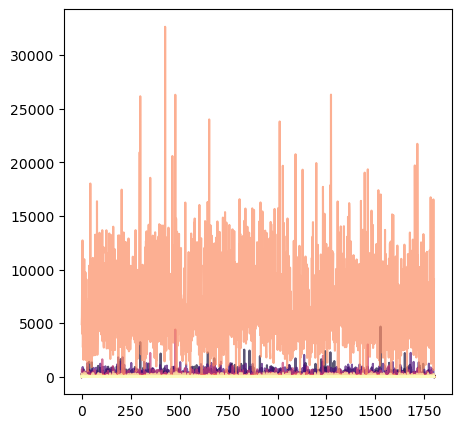

In [25]:
my_dict, my_comps = run_nmfac(data_v, clusters = 35)

cluster_groups = {}
for cluster_num in set(my_dict['Cluster_Number']):
    cluster_groups[cluster_num] = []

# Group the data based on cluster numbers
for cluster_num, int_angle in zip(my_dict['Cluster_Number'], my_dict['Int_Angle']):
    cluster_groups[cluster_num].append(int_angle)

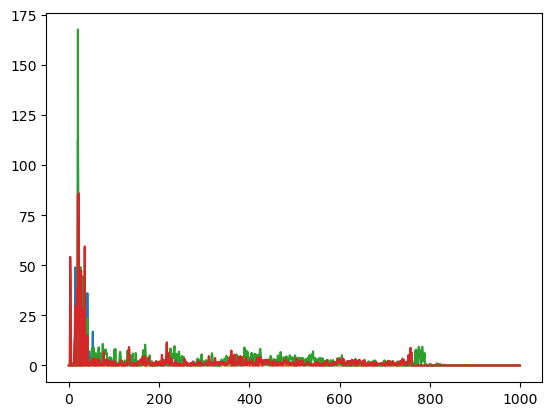

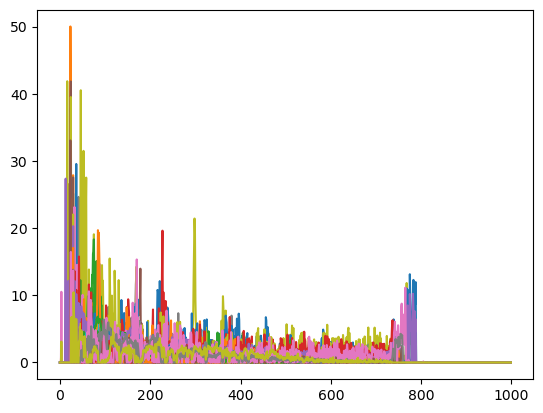

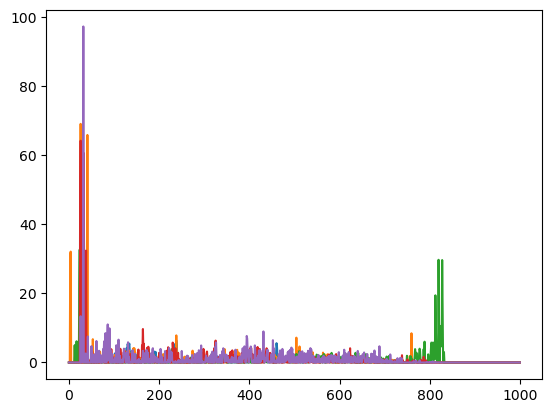

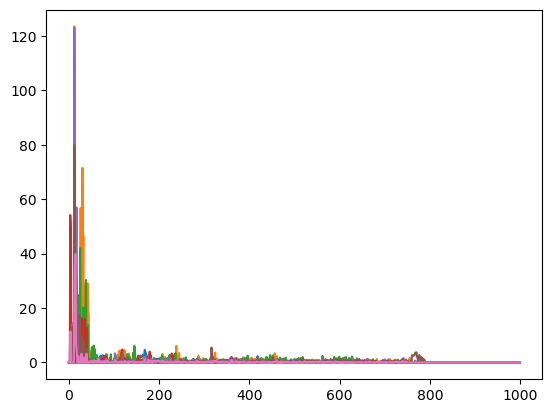

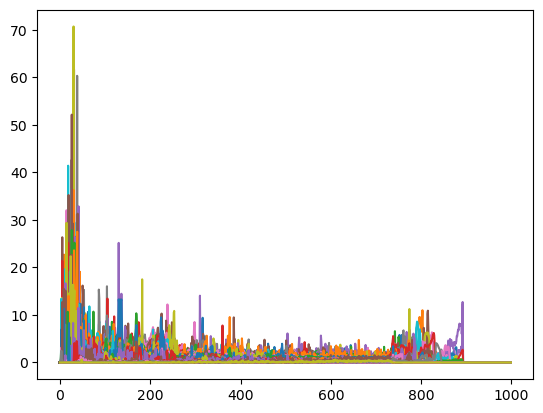

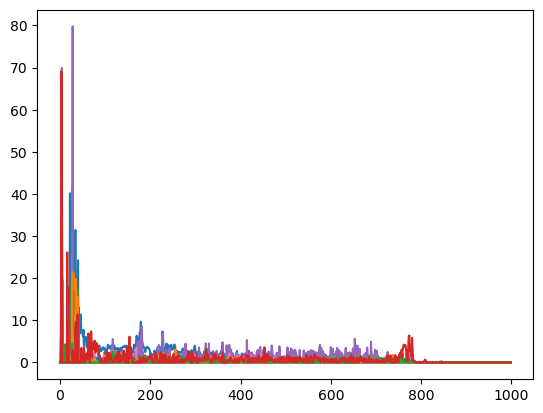

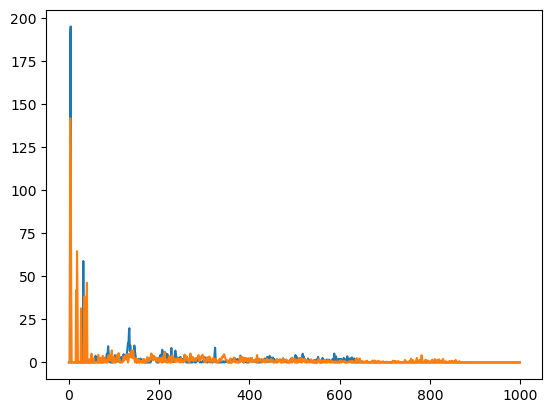

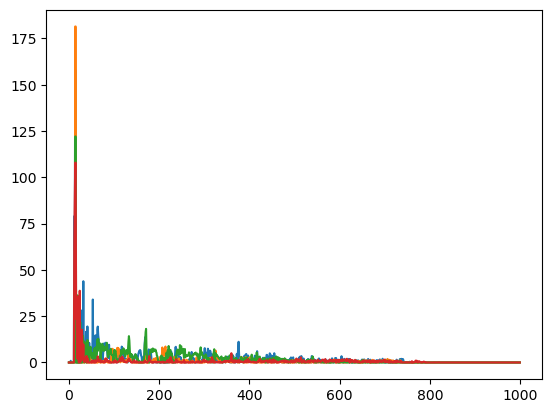

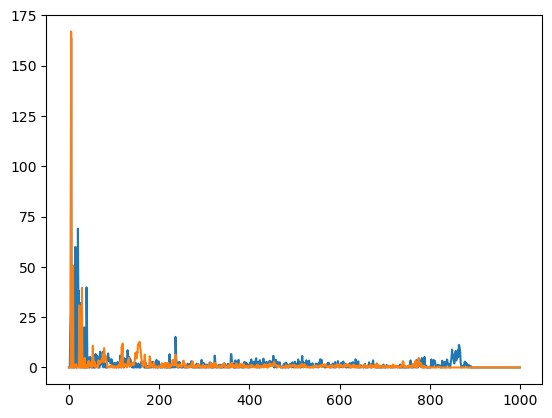

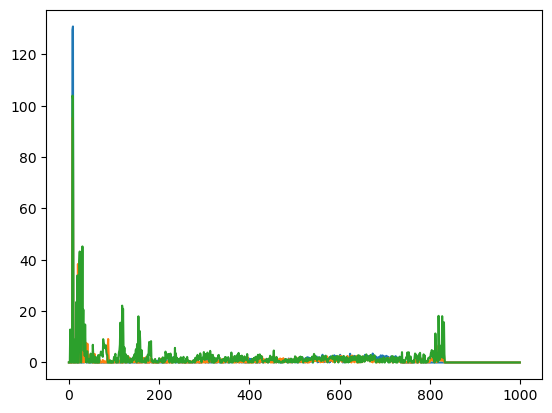

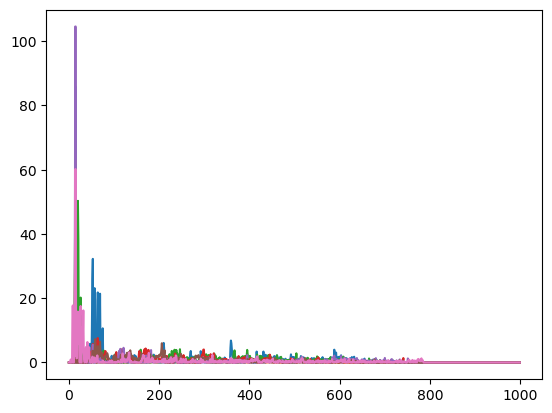

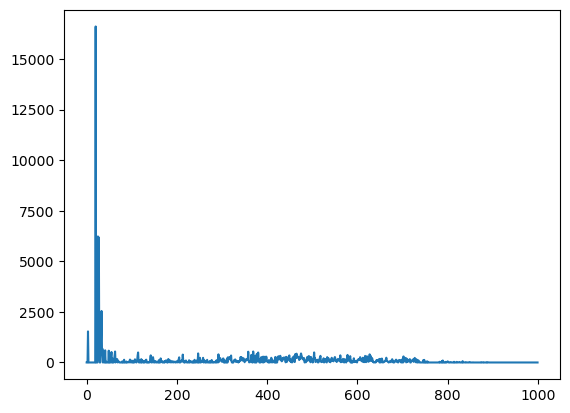

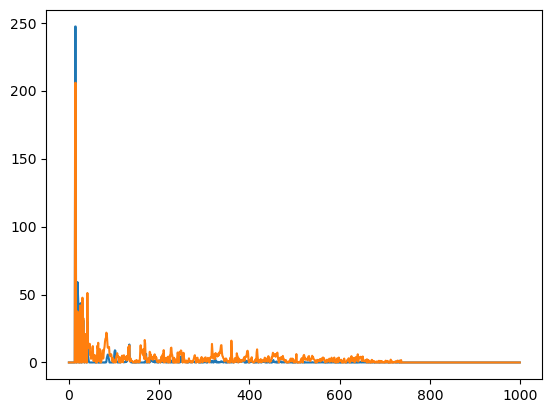

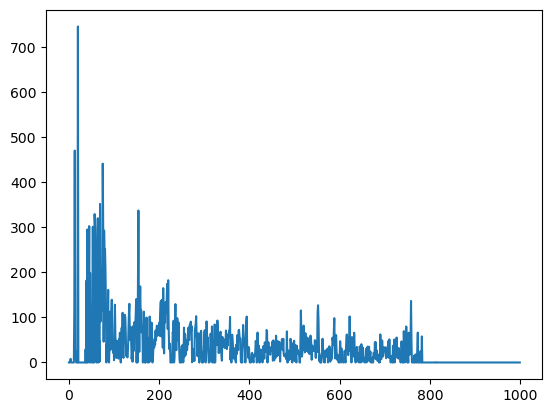

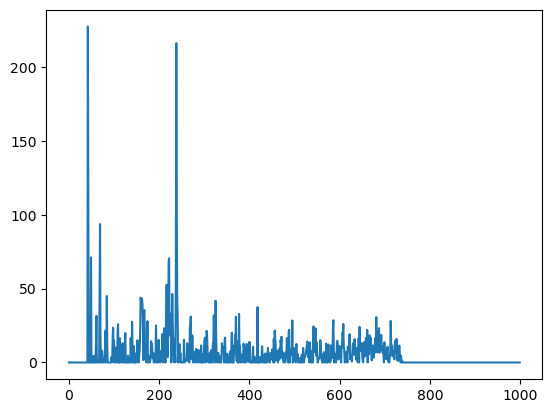

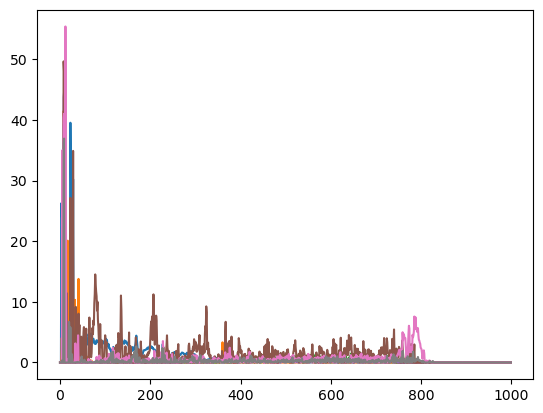

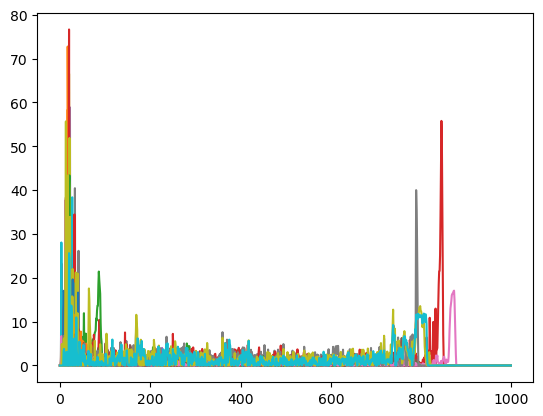

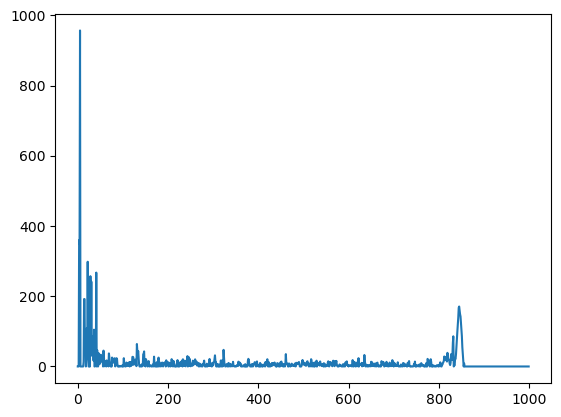

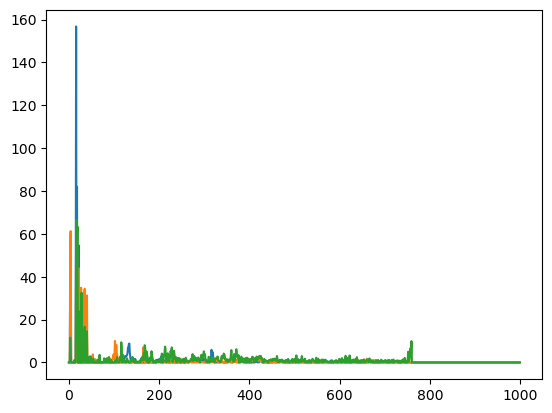

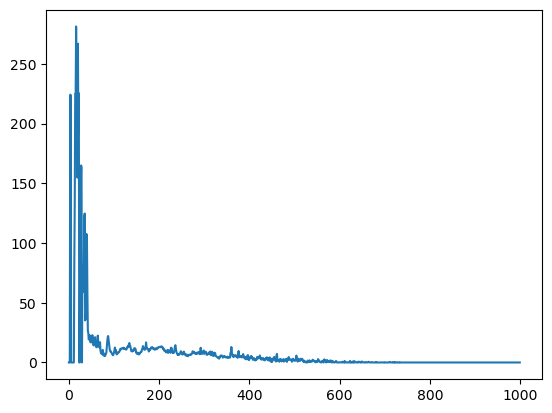

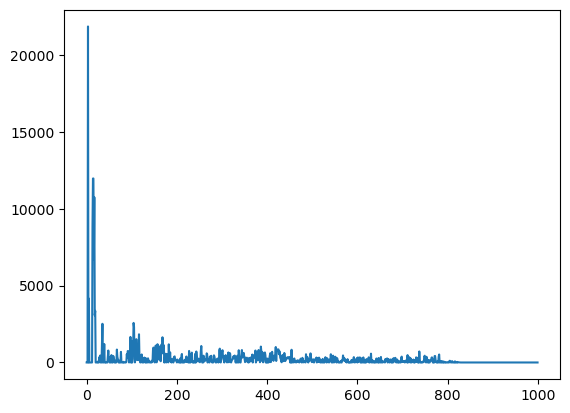

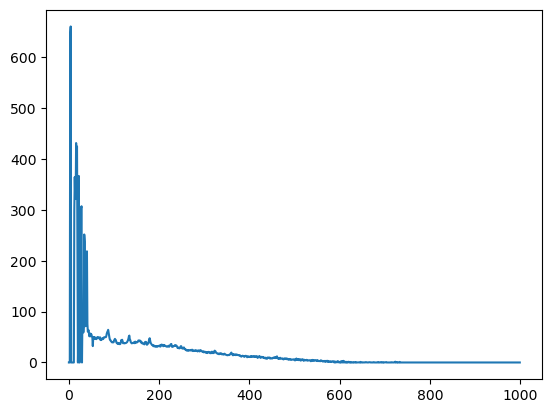

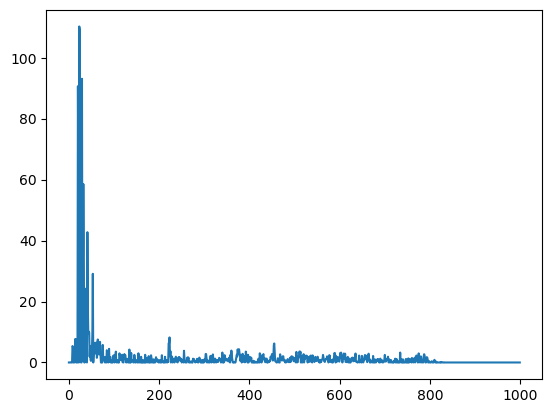

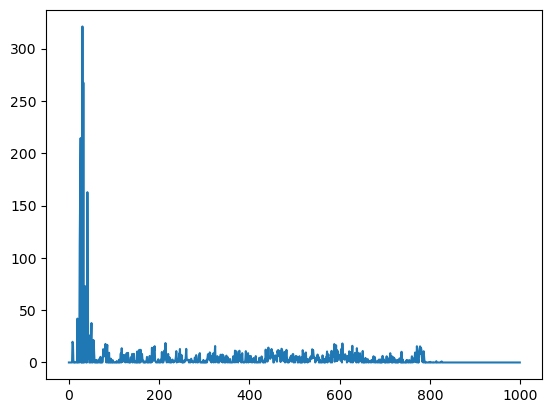

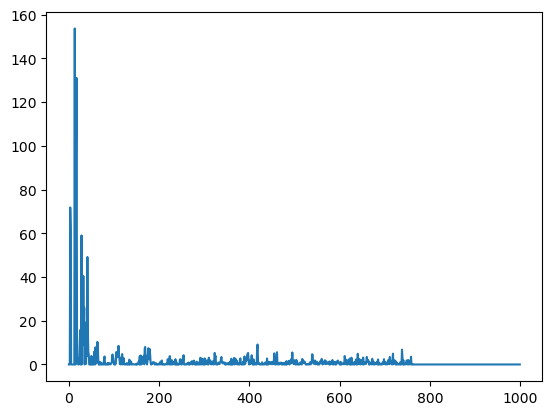

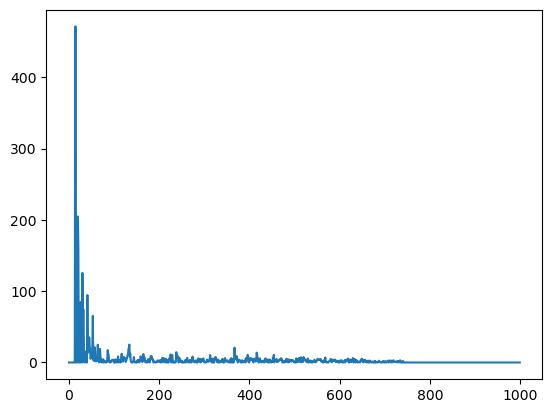

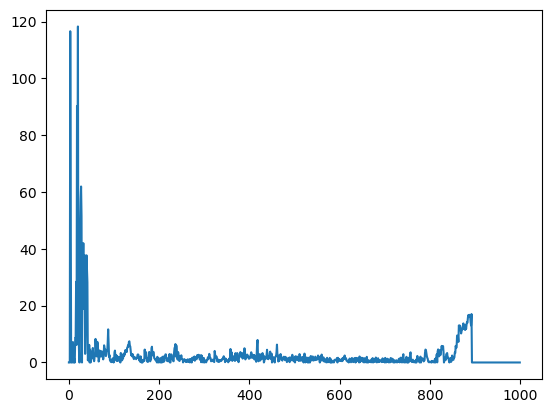

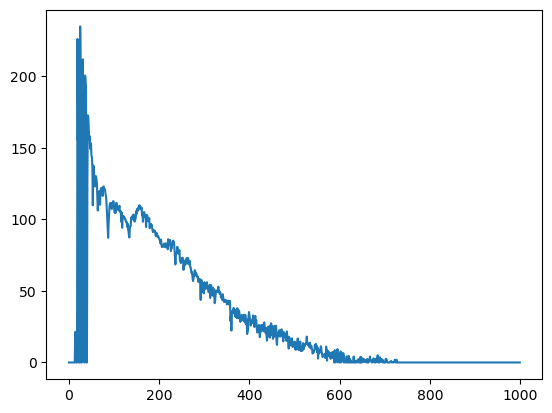

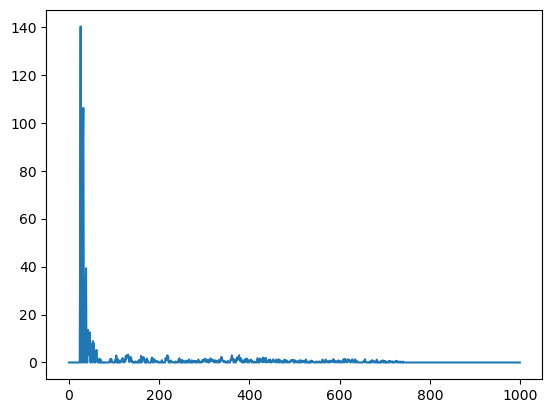

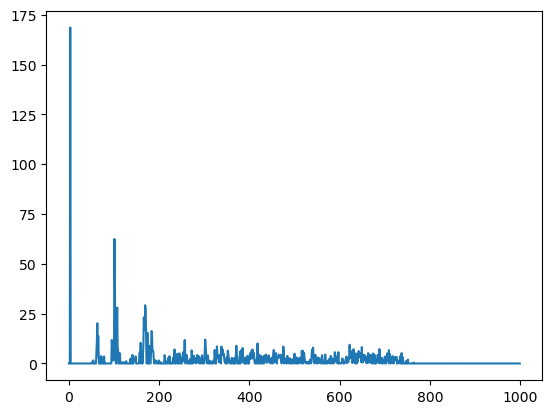

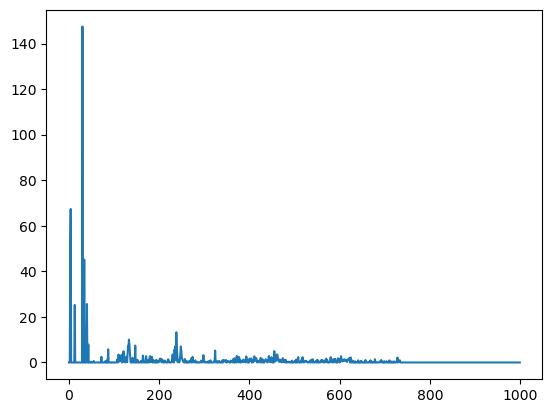

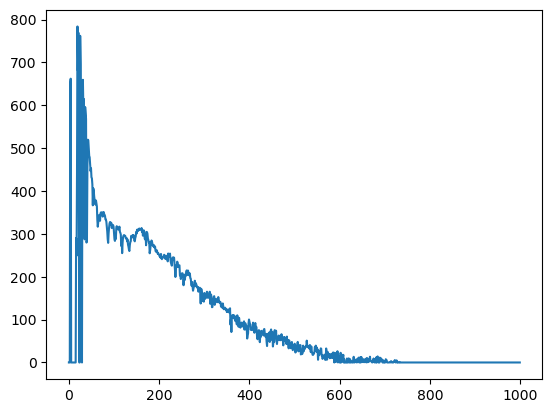

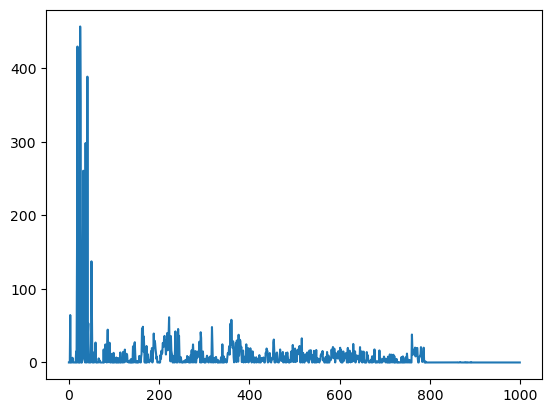

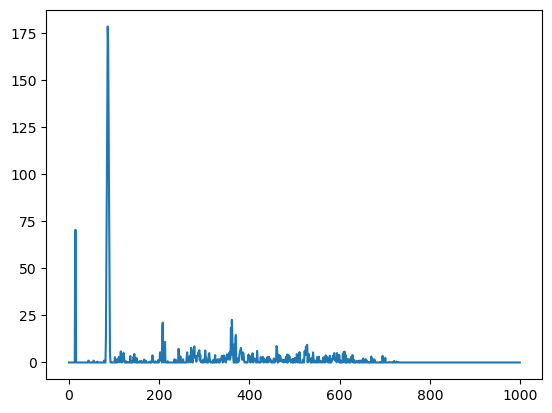

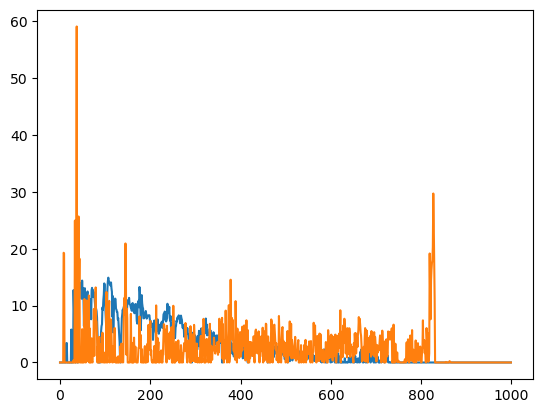

In [26]:
import matplotlib.pyplot as plt

for i in range(0, 35):
    plt.figure()
    for value in cluster_groups[i]:
        plt.plot(value)
    #plt.show()

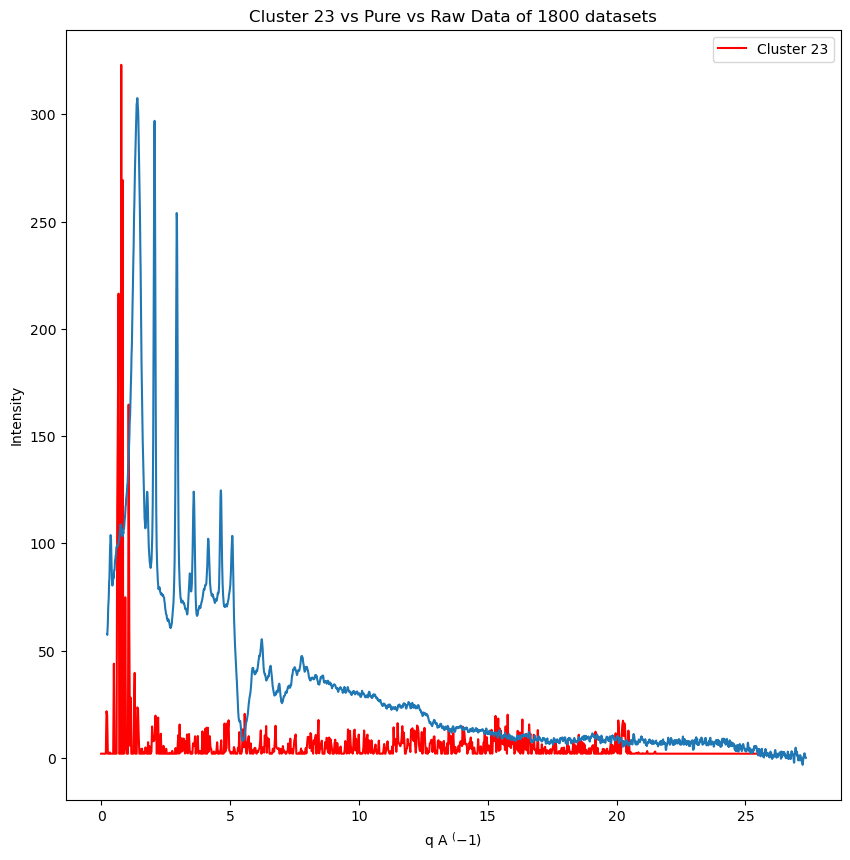

In [37]:
plt.figure(figsize = (10, 10))
plt.plot(new_q,(cluster_groups[23][0])+2, c= 'r', label = 'Cluster 23')
fs_data = np.array(real_ish_pd[0])

plt.plot(q_for_real, fs_data)

plt.legend()
plt.title('Cluster 23 vs Pure vs Raw Data of 1800 datasets')
plt.ylabel('Intensity')
plt.xlabel('q A $^(-1)$')
plt.show()

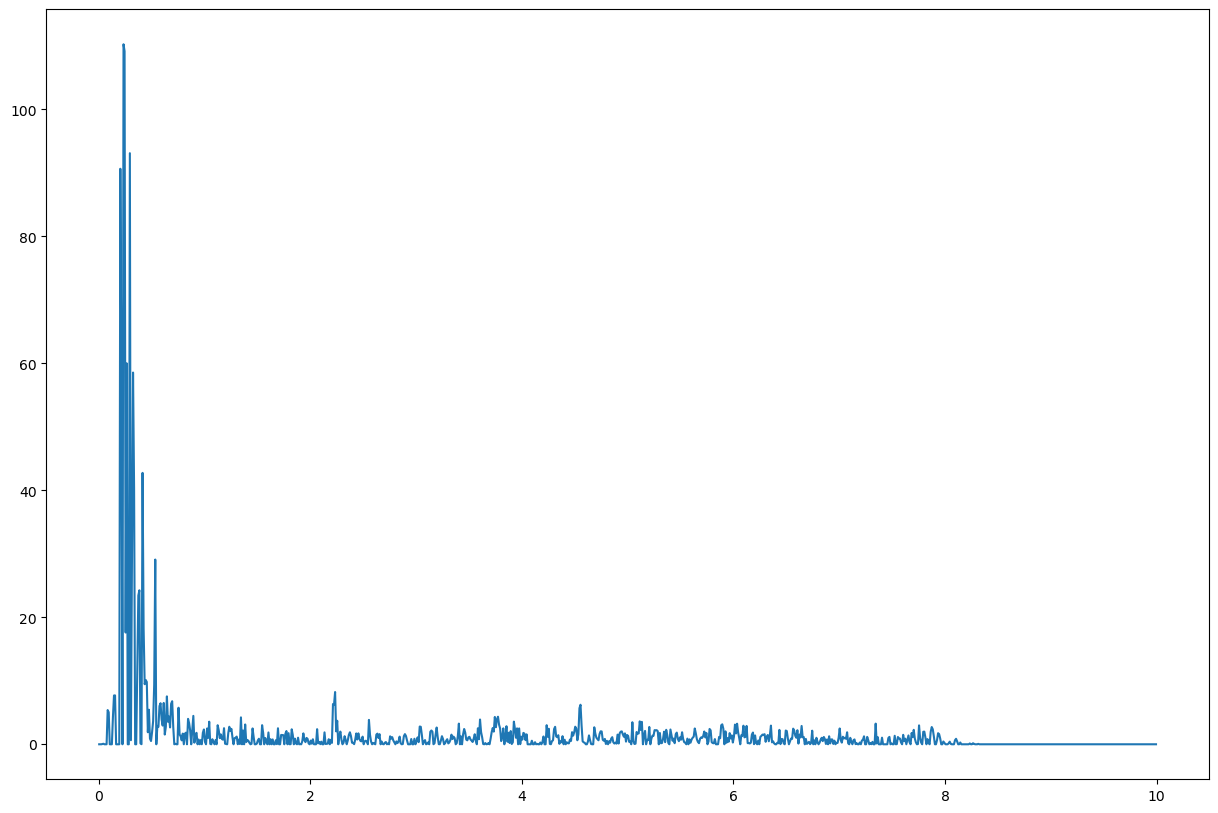

In [64]:
plt.figure(figsize = (15, 10))
plt.plot(q, cluster_groups[22][0])

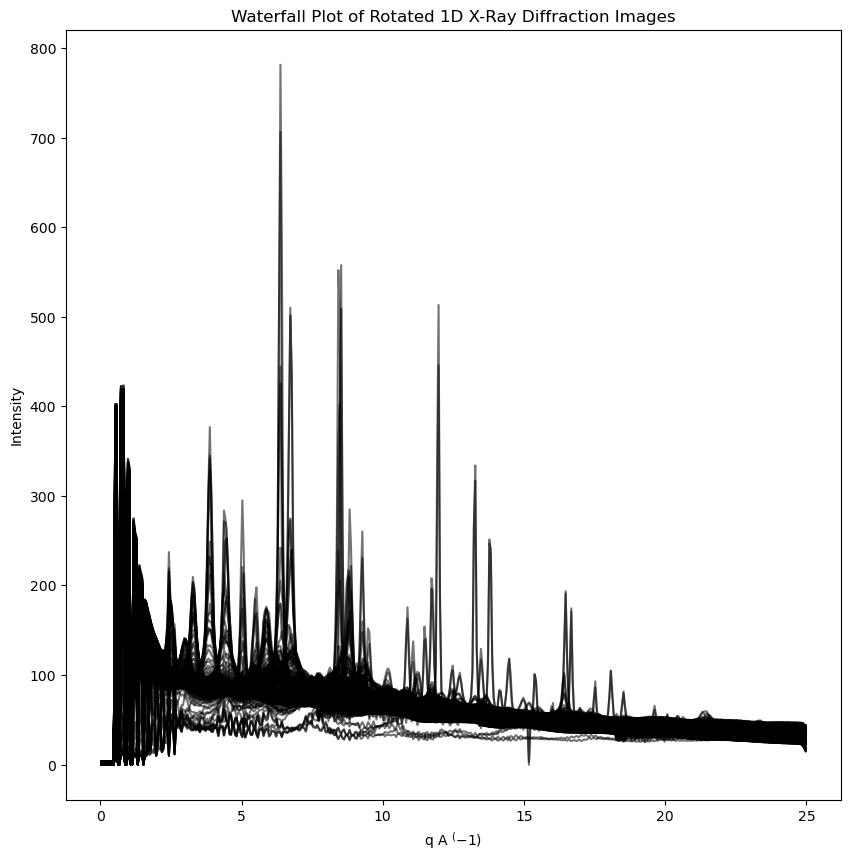

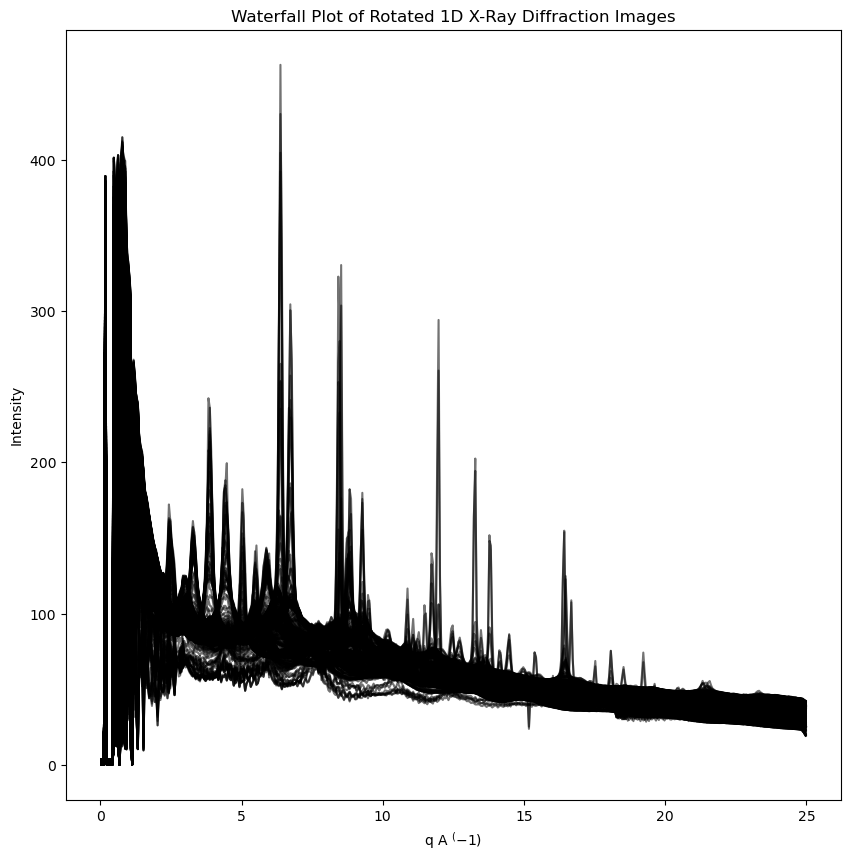

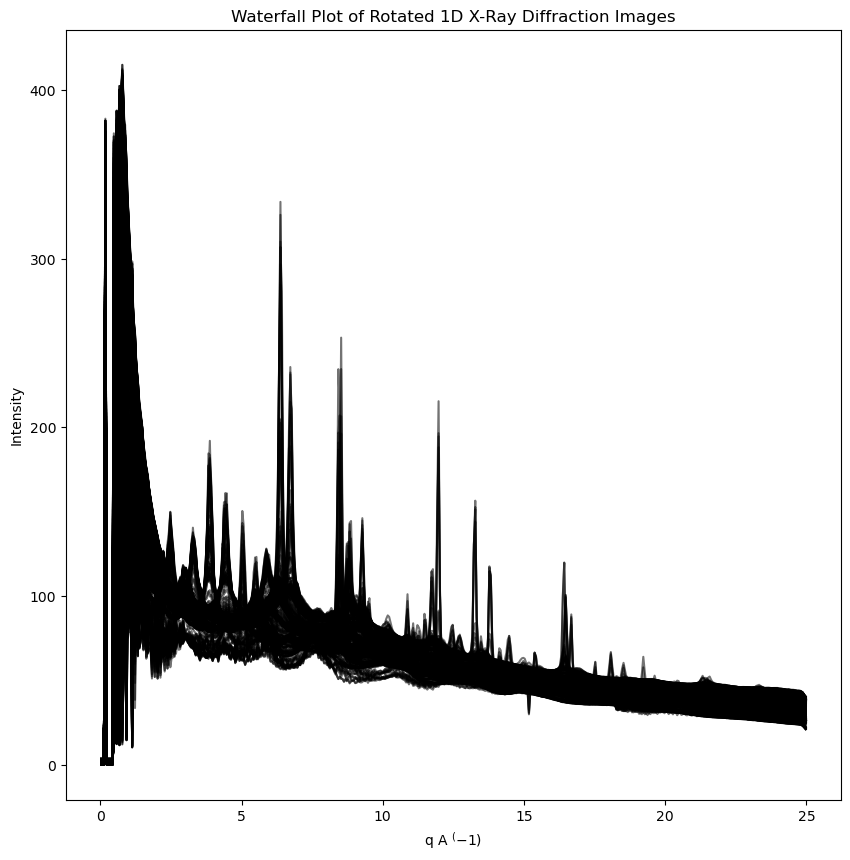

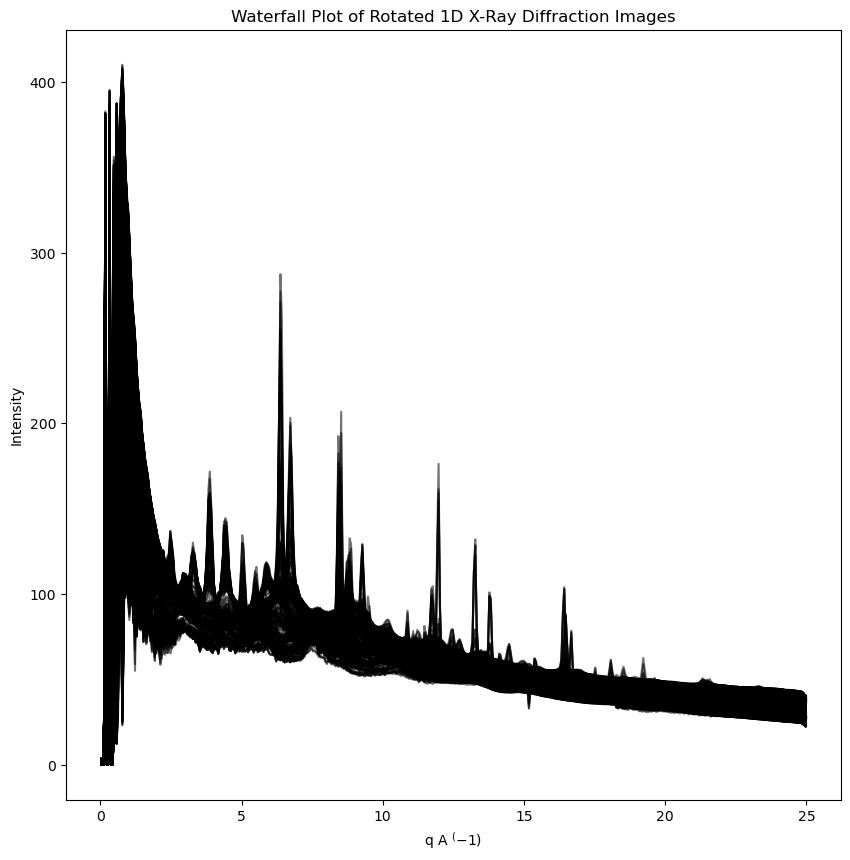

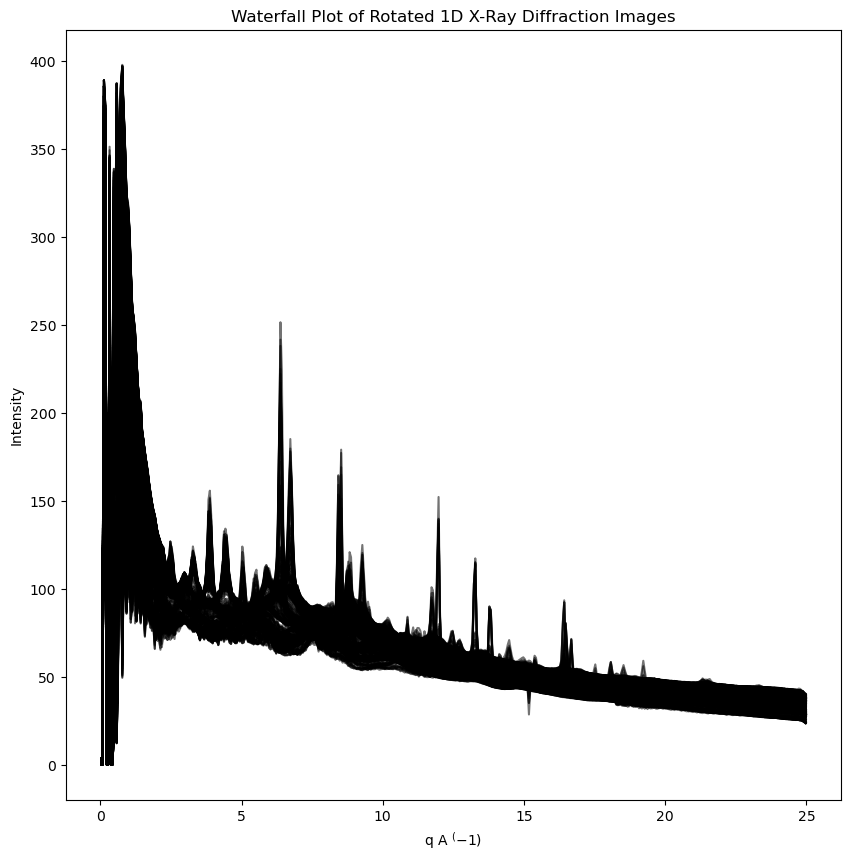

In [66]:
q, re_ints = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_one)
q, re_ints1 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_two)
q, re_ints2 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_three)
q, re_ints3 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_four)
q, re_ints4 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 500, mask = mask_five)

In [67]:
column_mapping = {}
for i in range(361, 721):
    column_mapping[(i - 361)] = (i)

re_ints1.rename(columns=column_mapping, inplace=True) 
   
column_mapping = {}
for i in range(722, 1082):
    column_mapping[(i - 722)] = (i)
print(column_mapping)

re_ints2.rename(columns=column_mapping, inplace=True) 
column_mapping = {}
for i in range(1083, 1443):
    column_mapping[(i - 1083)] = (i)
print(column_mapping)

re_ints3.rename(columns=column_mapping, inplace=True)    
column_mapping = {}
for i in range(1444, 1804):
    column_mapping[(i - 1444)] = (i)
    
re_ints4.rename(columns=column_mapping, inplace=True)  

{0: 722, 1: 723, 2: 724, 3: 725, 4: 726, 5: 727, 6: 728, 7: 729, 8: 730, 9: 731, 10: 732, 11: 733, 12: 734, 13: 735, 14: 736, 15: 737, 16: 738, 17: 739, 18: 740, 19: 741, 20: 742, 21: 743, 22: 744, 23: 745, 24: 746, 25: 747, 26: 748, 27: 749, 28: 750, 29: 751, 30: 752, 31: 753, 32: 754, 33: 755, 34: 756, 35: 757, 36: 758, 37: 759, 38: 760, 39: 761, 40: 762, 41: 763, 42: 764, 43: 765, 44: 766, 45: 767, 46: 768, 47: 769, 48: 770, 49: 771, 50: 772, 51: 773, 52: 774, 53: 775, 54: 776, 55: 777, 56: 778, 57: 779, 58: 780, 59: 781, 60: 782, 61: 783, 62: 784, 63: 785, 64: 786, 65: 787, 66: 788, 67: 789, 68: 790, 69: 791, 70: 792, 71: 793, 72: 794, 73: 795, 74: 796, 75: 797, 76: 798, 77: 799, 78: 800, 79: 801, 80: 802, 81: 803, 82: 804, 83: 805, 84: 806, 85: 807, 86: 808, 87: 809, 88: 810, 89: 811, 90: 812, 91: 813, 92: 814, 93: 815, 94: 816, 95: 817, 96: 818, 97: 819, 98: 820, 99: 821, 100: 822, 101: 823, 102: 824, 103: 825, 104: 826, 105: 827, 106: 828, 107: 829, 108: 830, 109: 831, 110: 832,

In [69]:
data_v = pd.concat([re_ints, re_ints1, re_ints2, re_ints3, re_ints4], axis = 1)
data_v

0          1          2          3          4          5     \
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
495  22.818493  23.000200  23.017139  22.851295  23.148540  23.539877   
496  22.281626  22.557184  22.681950  22.701387  22.668217  23.081873   
497  20.822754  20.813084  21.306486  21.423277  21.462484  21.271263   
498  18.764545  18.827194  18.560801  17.780293  18.030176  18.422817   
499  17.528551  16.808401  15.622362  14.671877  14.812544  15.286138   

          6          7          8          9     ...        1794        1795  \
0     0.000000   0.000000   0.000000   0.000000  ...    0.000000    0.000000   
1     0.000000   0.000000   0.000000   0.000000  ...    0.000000    0.000000   
2     0.000000   0.000000   0.000000   0.000000  ...  342.580383  342.580383   
3     0.000000   0.000000   0.000000   0.000000  ...  323.870941  323.870941   
4     0.000000   0.000000   0.000000   0.000000  ...    0.000000    0.000000   
..         ...        ...        ...        ...  ...         ...         ...   
495  23.363621  23.691904  23.097294  23.411713  ...   26.039705   25.777609   
496  22.941246  23.219009  22.582930  22.926945  ...   25.988913   25.759716   
497  21.403662  21.300926  20.869797  21.197487  ...   25.375759   25.277931   
498  18.848978  19.423351  19.158577  19.412880  ...   24.833845   24.842157   
499  16.236137  17.641474  17.881069  18.106117  ...   24.200558   24.309147   

           1796        1797        1798        1799        1800        1801  \
0      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
1      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
2    342.580383  329.936523  331.520996  331.520996  331.520996  331.520996   
3    323.870941  319.778961  320.291748  320.270111  320.270111  320.270111   
4      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
..          ...         ...         ...         ...         ...         ...   
495   25.880136   25.580416   25.669657   25.455132   25.524061   25.380976   
496   25.828012   25.632570   25.596668   25.485697   25.428986   25.484177   
497   25.200092   25.069502   25.158417   24.992517   24.960411   24.986750   
498   24.793121   24.693768   24.568336   24.335863   24.257429   24.310772   
499   24.415110   24.320158   24.051090   23.814001   23.693222   23.674925   

           1802        1803  
0      0.000000    0.000000  
1      0.000000    0.000000  
2    331.520996  331.520996  
3    320.270111  320.270111  
4      0.000000    0.000000  
..          ...         ...  
495   25.404739   25.426908  
496   25.300617   25.337896  
497   24.782400   24.866722  
498   24.269268   24.458523  
499   23.815445   24.062727  

[500 rows x 1800 columns]

          206        350         820         382         741         660   \
0     0.000000   0.000000    0.000000    0.000000    0.000000    0.000000   
1     0.000000   0.000000    0.000000    0.000000    0.000000    0.000000   
2     0.000000   0.000000    0.000000    0.000000    0.000000    0.000000   
3     0.000000   0.000000  340.313141  310.288788  312.802673  361.714569   
4     0.000000   0.000000    0.000000    0.000000    0.000000    0.000000   
..         ...        ...         ...         ...         ...         ...   
495  27.286894  24.040655   40.178982   25.196510   25.352898   37.591179   
496  27.537554  23.955688   40.143772   25.048683   25.153570   37.483059   
497  27.144283  23.557861   39.798565   24.717283   24.462515   37.465755   
498  26.995848  23.576048   39.031994   24.441225   23.108496   37.191784   
499  27.029177  23.607876   37.756874   23.221514   22.083857   37.098019   

           1276        1193        1448        728   ...        1208  \
0  

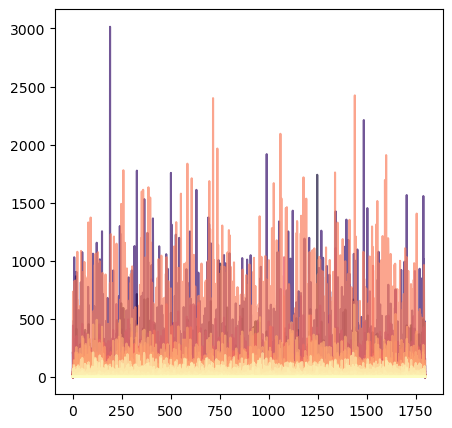

In [74]:
my_dict, my_comps = run_nmfac(data_v, clusters = 40)

cluster_groups = {}
for cluster_num in set(my_dict['Cluster_Number']):
    cluster_groups[cluster_num] = []

# Group the data based on cluster numbers
for cluster_num, int_angle in zip(my_dict['Cluster_Number'], my_dict['Int_Angle']):
    cluster_groups[cluster_num].append(int_angle)

In [72]:
import pandas as pd

# Assuming your DataFrame is named df
# Count the number of negative values in the DataFrame
negative_values_count = (data_v < 0).sum().sum()

print("The number of negative values in the DataFrame:", negative_values_count)

The number of negative values in the DataFrame: 2


In [73]:
data_v = data_v.clip(lower=0)

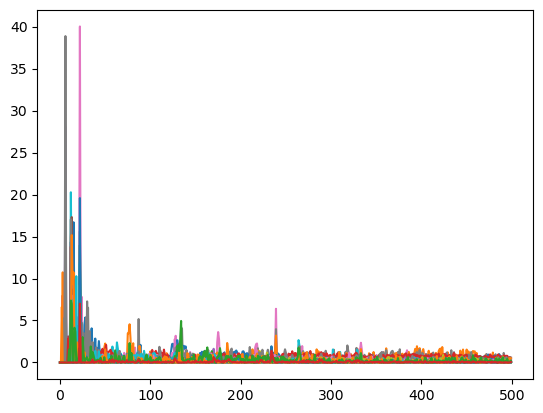

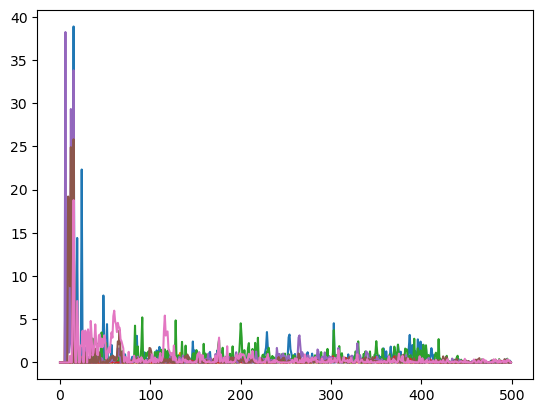

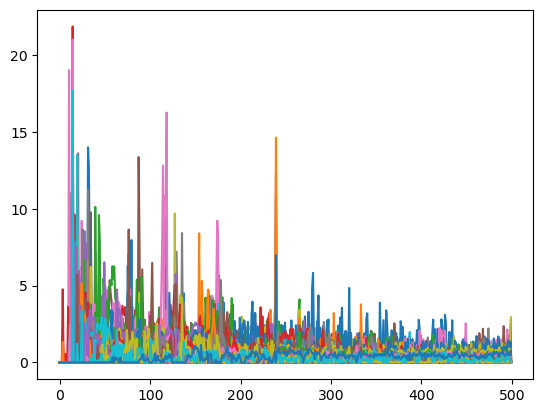

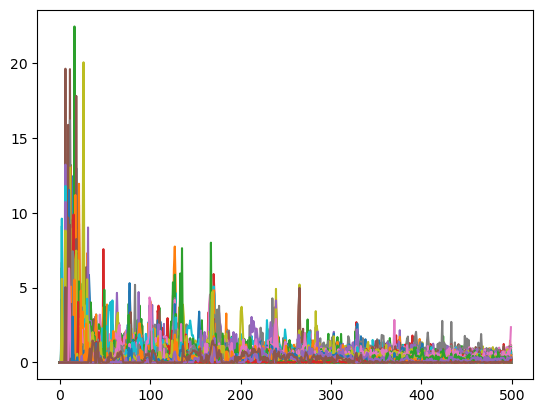

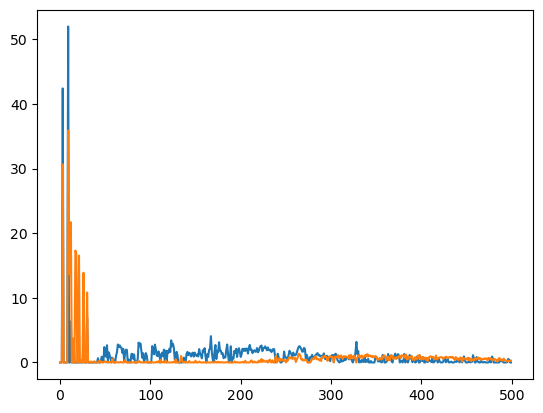

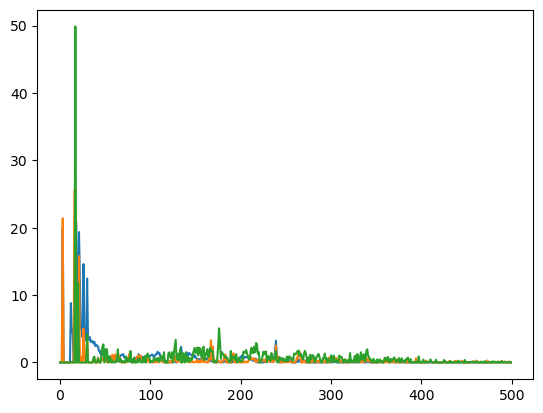

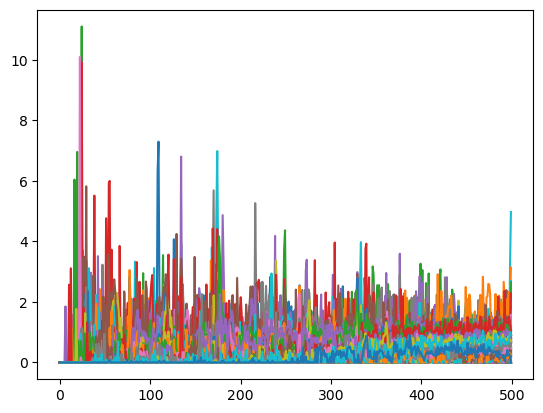

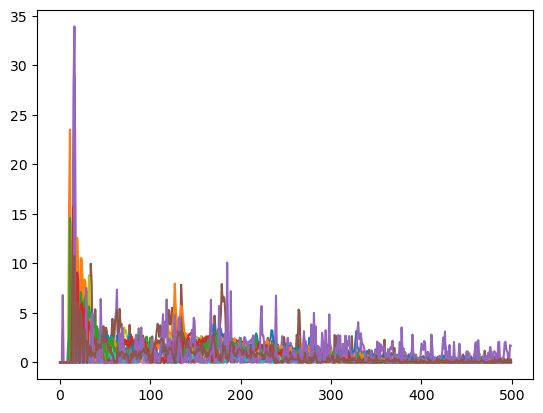

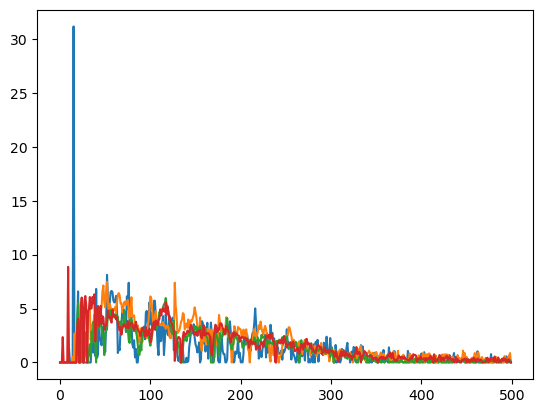

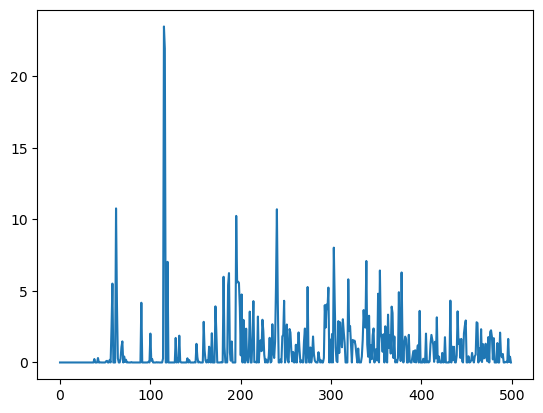

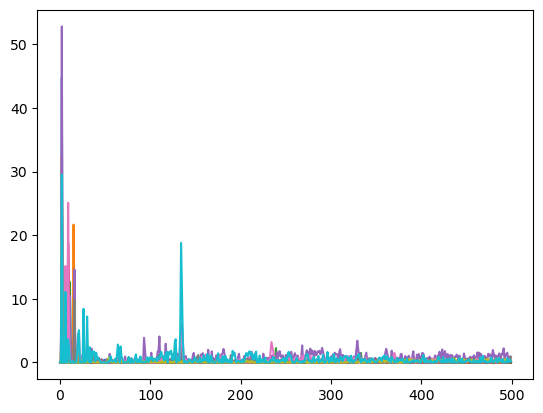

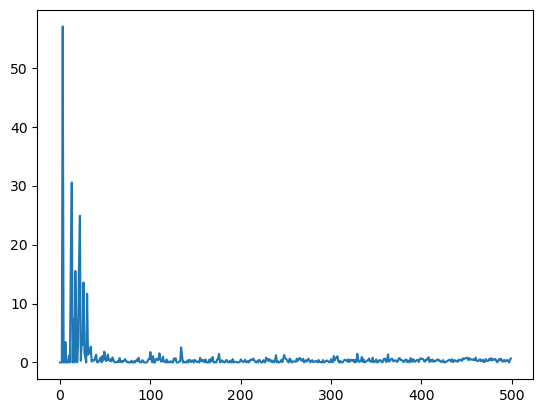

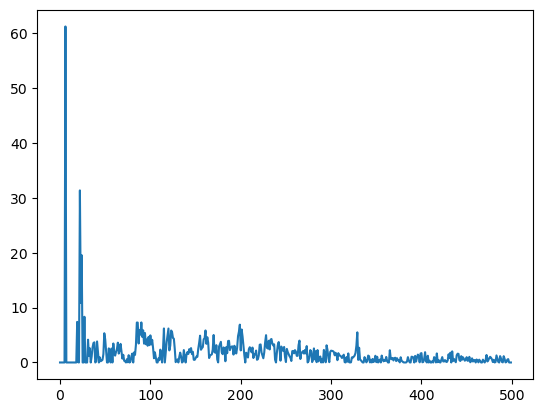

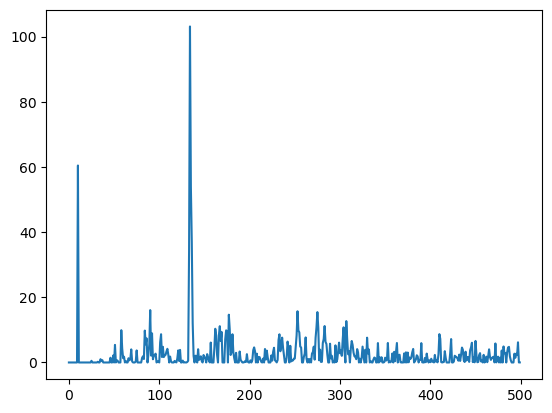

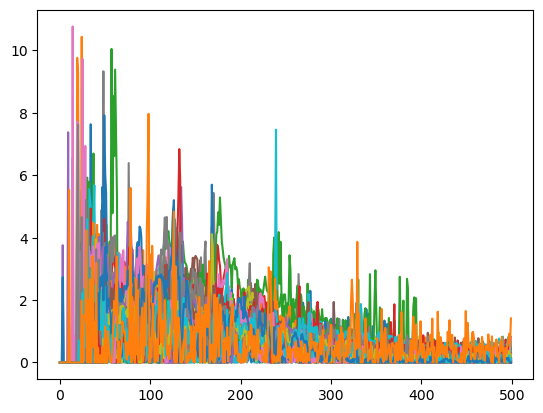

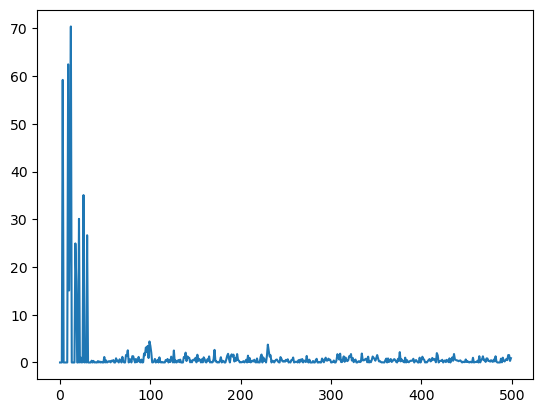

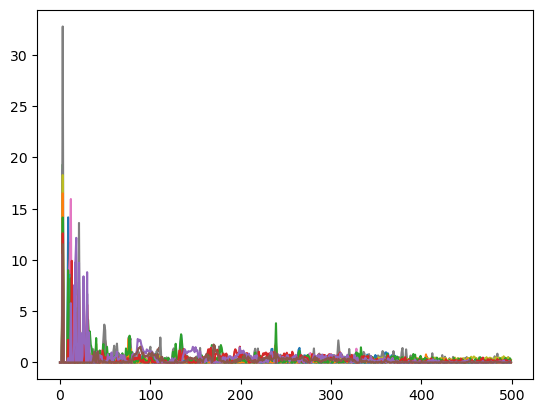

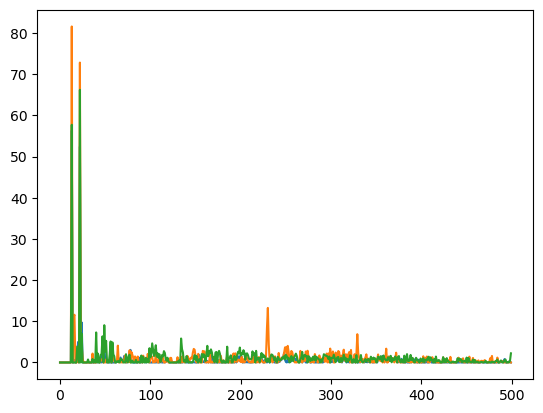

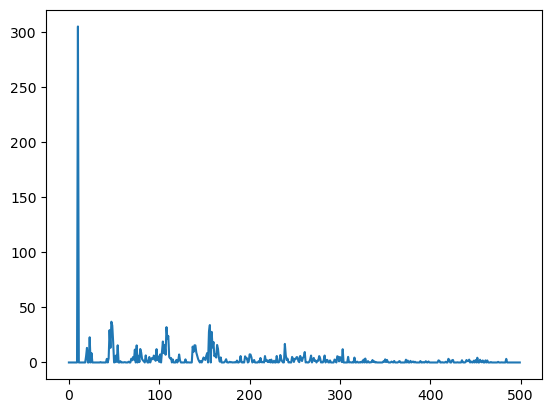

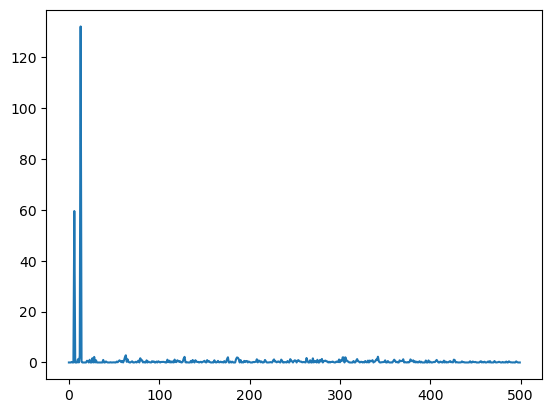

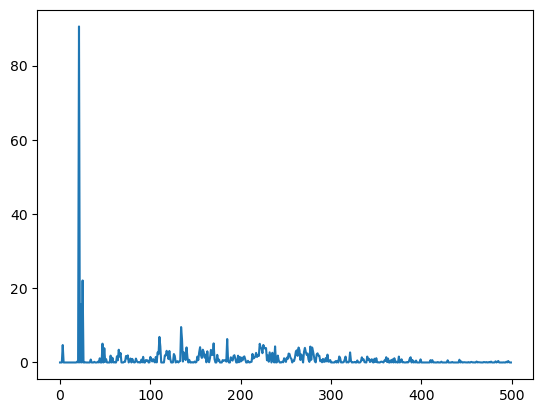

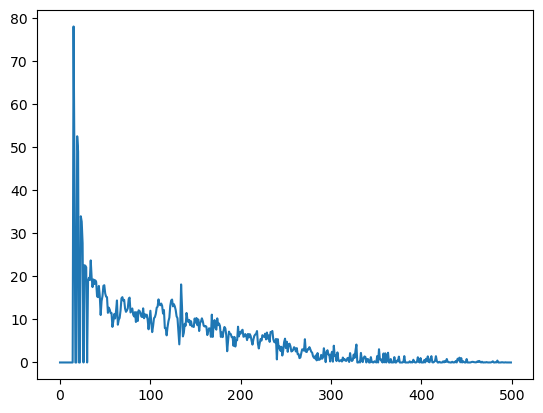

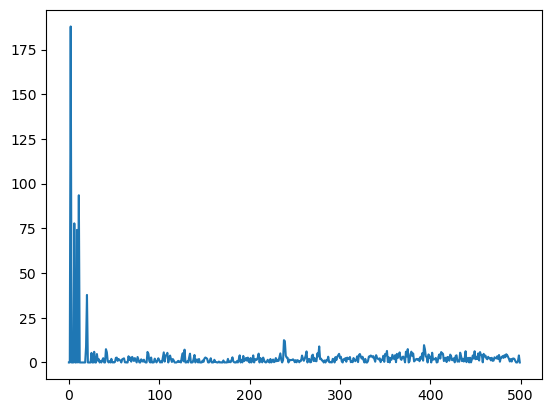

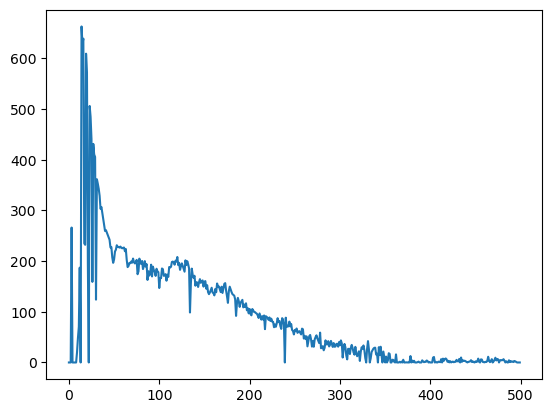

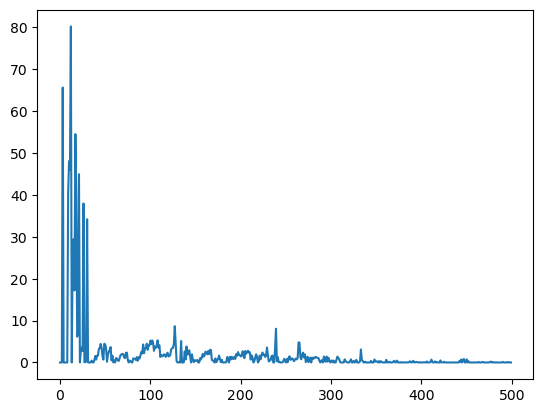

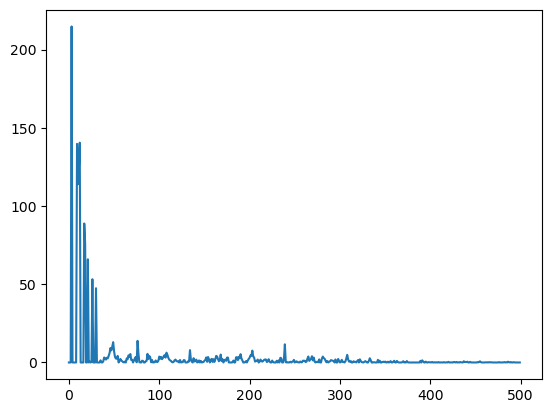

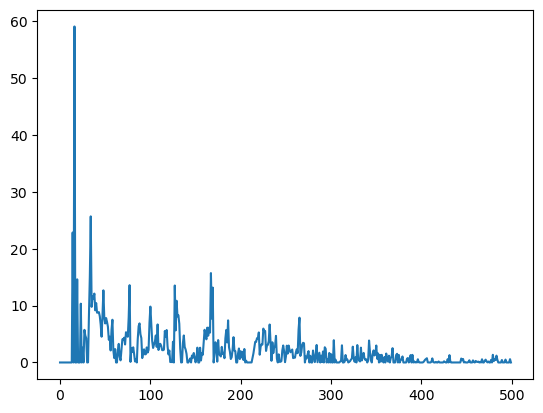

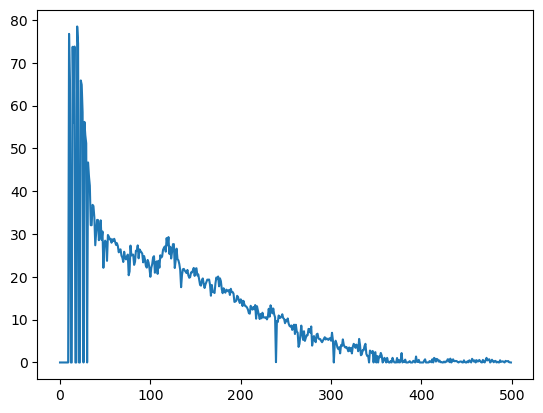

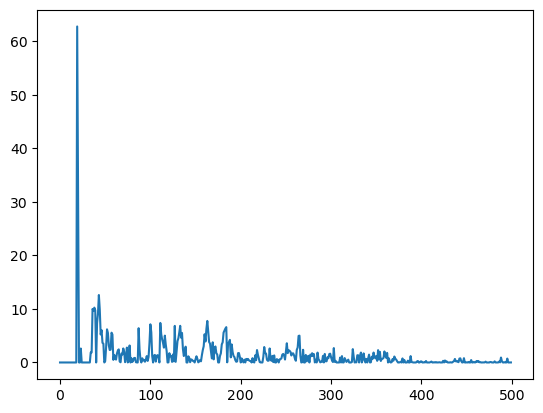

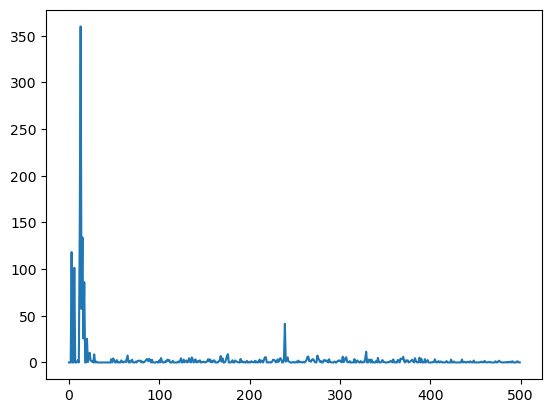

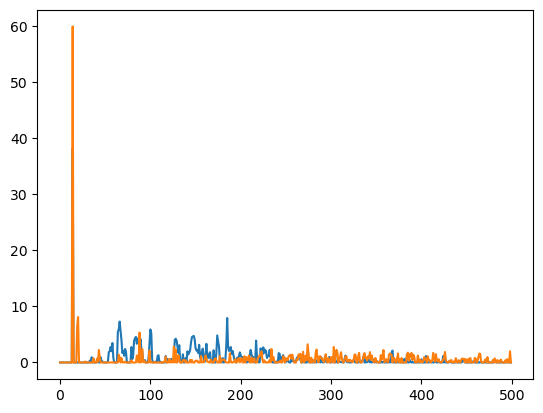

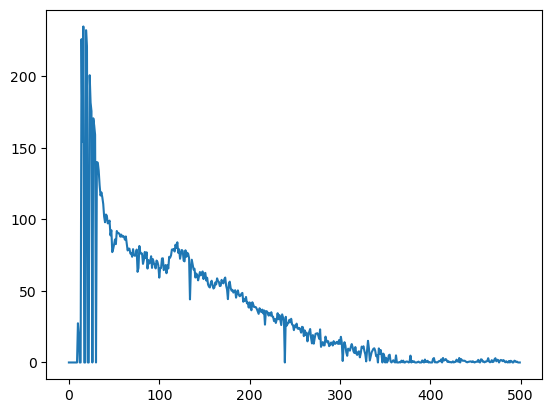

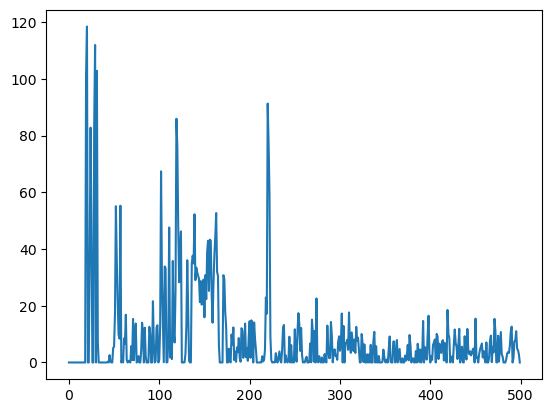

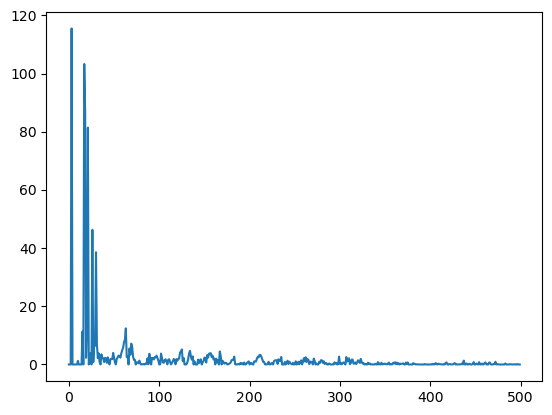

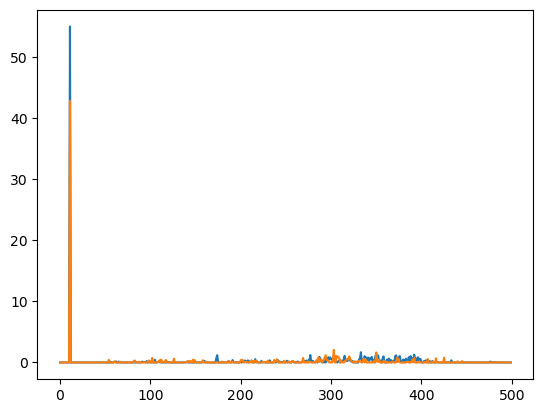

In [75]:
import matplotlib.pyplot as plt

for i in range(0, 35):
    plt.figure()
    for value in cluster_groups[i]:
        plt.plot(value)
    #plt.show()

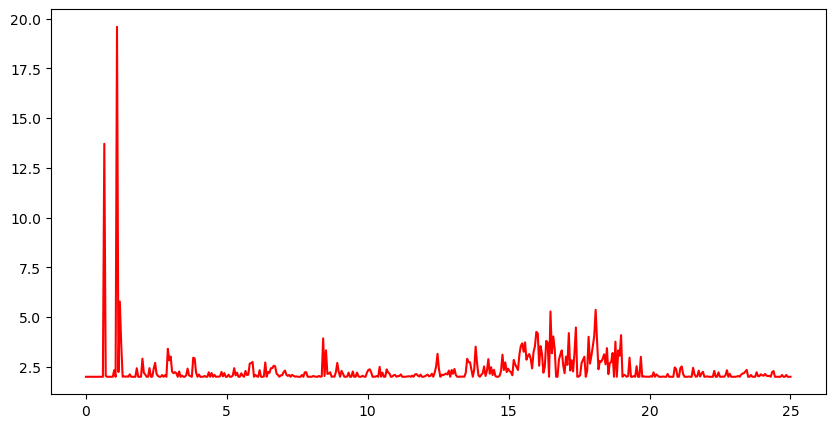

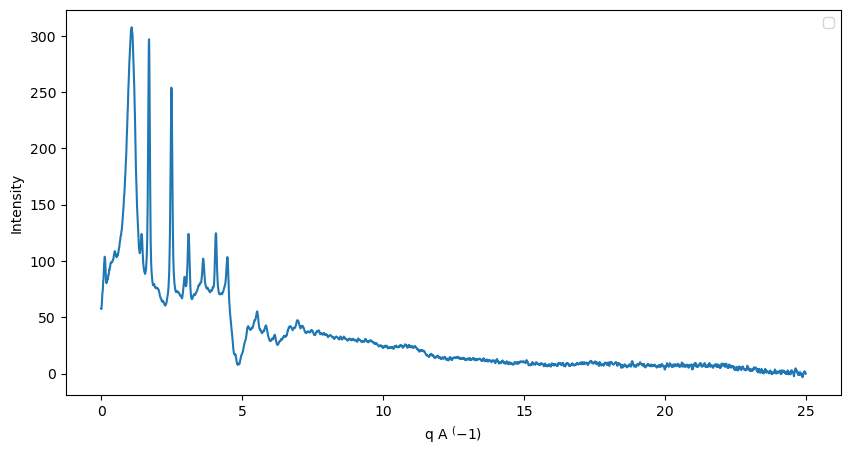

In [140]:
plt.figure(figsize = (10,5))
plt.plot(q_for_clusters,(cluster_groups[0][1]*2)+2, c= 'r', label = 'Cluster 23')
plt.figure(figsize = (10, 5))
#fs_data = np.array(real_ish_pd[0])

plt.plot(q_for_fs, fs_data)

plt.legend()
#plt.title('Cluster 23 vs Pure vs Raw Data of 1800 datasets')
plt.ylabel('Intensity')
plt.xlabel('q A $^(-1)$')
plt.show()

In [103]:
q_for_fs = np.linspace(0, 25, 3000)
q_for_clusters = np.linspace(0, 25, 500)

In [142]:
os.chdir(r'/blue/mbutala/dalverson/')
file_list = sorted(glob.glob('VESTA_GST_Signal_Q.xy'))
real_ish = read_all_into_list(file_list)

vesta = pd.DataFrame(real_ish)

q_for_vesta = vesta.index

In [148]:
len(vesta)

11900

Text(0.5, 1.0, 'VESTA GST Signal')

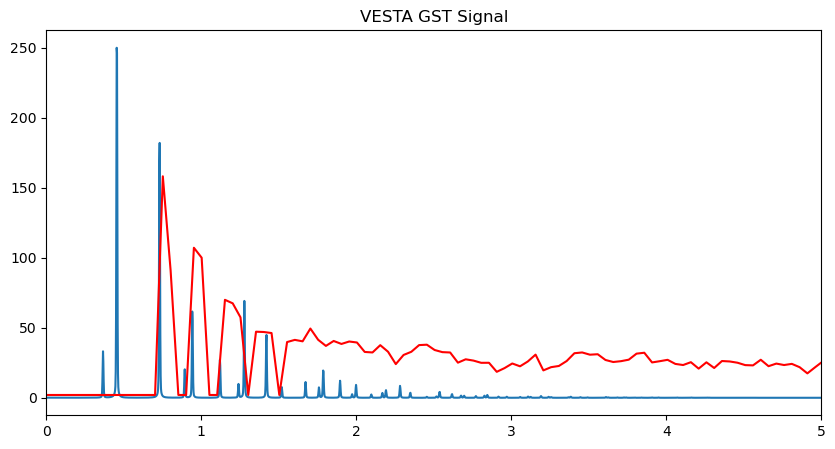

In [157]:
plt.figure(figsize = (10,5))
plt.plot(q_for_vesta_new, vesta)
plt.plot(q_for_clusters,(cluster_groups[21][0]*2)+2, c= 'r', label = 'Cluster 23')
plt.xlim(0, 5)
plt.title('VESTA GST Signal')

In [149]:
q_for_vesta_new = np.linspace(0, 25, 11900)

In [154]:
q_for_clusters

array([ 0.        ,  0.0501002 ,  0.1002004 ,  0.1503006 ,  0.2004008 ,
        0.250501  ,  0.3006012 ,  0.3507014 ,  0.4008016 ,  0.4509018 ,
        0.501002  ,  0.5511022 ,  0.6012024 ,  0.65130261,  0.70140281,
        0.75150301,  0.80160321,  0.85170341,  0.90180361,  0.95190381,
        1.00200401,  1.05210421,  1.10220441,  1.15230461,  1.20240481,
        1.25250501,  1.30260521,  1.35270541,  1.40280561,  1.45290581,
        1.50300601,  1.55310621,  1.60320641,  1.65330661,  1.70340681,
        1.75350701,  1.80360721,  1.85370741,  1.90380762,  1.95390782,
        2.00400802,  2.05410822,  2.10420842,  2.15430862,  2.20440882,
        2.25450902,  2.30460922,  2.35470942,  2.40480962,  2.45490982,
        2.50501002,  2.55511022,  2.60521042,  2.65531062,  2.70541082,
        2.75551102,  2.80561122,  2.85571142,  2.90581162,  2.95591182,
        3.00601202,  3.05611222,  3.10621242,  3.15631263,  3.20641283,
        3.25651303,  3.30661323,  3.35671343,  3.40681363,  3.45

Text(0.5, 1.0, 'VESTA GST Signal')

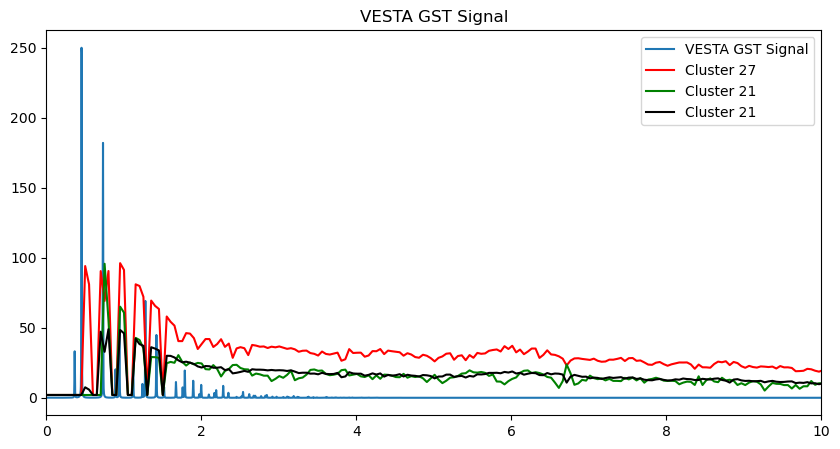

In [215]:
plt.figure(figsize = (10,5))
plt.plot(q_for_vesta_new, vesta, label = 'VESTA GST Signal')
plt.plot(q_for_clusters,(cluster_groups[27][0]*1.2)+2, c= 'r', label = 'Cluster 27')
plt.plot(q_for_clusters,(cluster_groups[21][0]*1.2)+2, c= 'g', label = 'Cluster 21')
plt.plot(q_for_clusters,(cluster_groups[31][0]*.2)+2, c= 'k', label = 'Cluster 21')
plt.xlim(0, 10)
plt.legend()
plt.title('VESTA GST Signal')

In [216]:
avg_data = np.mean([cluster_groups[27][0], cluster_groups[21][0], cluster_groups[31][0]], axis = 0)

Text(0.5, 1.0, 'VESTA GST Signal')

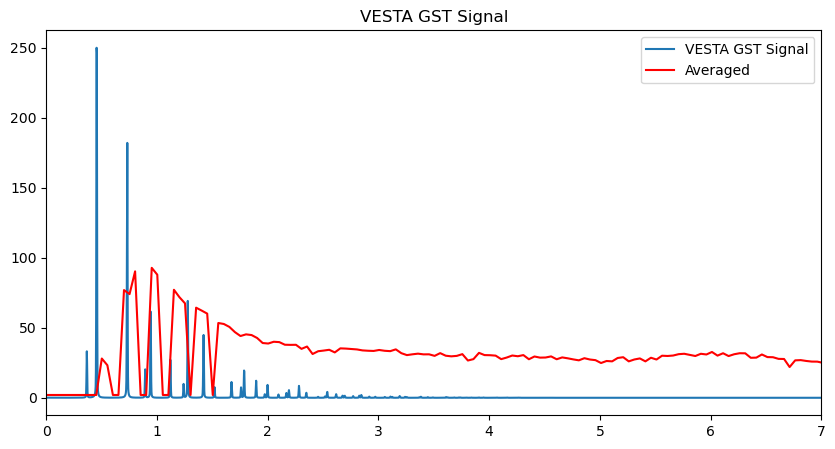

In [223]:
plt.figure(figsize = (10,5))
plt.plot(q_for_vesta_new, vesta, label = 'VESTA GST Signal')
plt.plot(q_for_clusters,(avg_data*.75)+2, c= 'r', label = 'Averaged')
#plt.plot(q_for_real, fs_data, label = ' FS Real Data')
#plt.plot(q_for_clusters,(cluster_groups[21][0]*1.2)+2, c= 'g', label = 'Cluster 21')
#plt.plot(q_for_clusters,(cluster_groups[31][0]*.2)+2, c= 'k', label = 'Cluster 21')
plt.xlim(0, 7)
plt.legend()
plt.title('VESTA GST Signal')

In [232]:
#going to smooth the average data using scipy's savgol filter
import scipy

smoothed_avg = scipy.signal.savgol_filter(avg_data, 3, 2)

Text(0.5, 1.0, 'VESTA GST Signal')

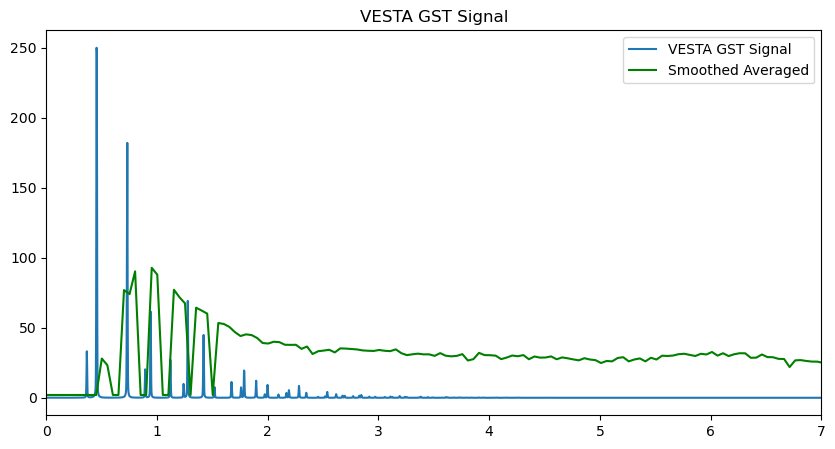

In [233]:
plt.figure(figsize = (10,5))
plt.plot(q_for_vesta_new, vesta, label = 'VESTA GST Signal')
#plt.plot(q_for_clusters,(avg_data*.75)+2, c= 'r', label = 'Averaged')
plt.plot(q_for_clusters,(smoothed_avg*.75)+2, c= 'g', label = 'Smoothed Averaged')
#plt.plot(q_for_real, fs_data, label = ' FS Real Data')
#plt.plot(q_for_clusters,(cluster_groups[21][0]*1.2)+2, c= 'g', label = 'Cluster 21')
#plt.plot(q_for_clusters,(cluster_groups[31][0]*.2)+2, c= 'k', label = 'Cluster 21')
plt.xlim(0, 7)
plt.legend()
plt.title('VESTA GST Signal')

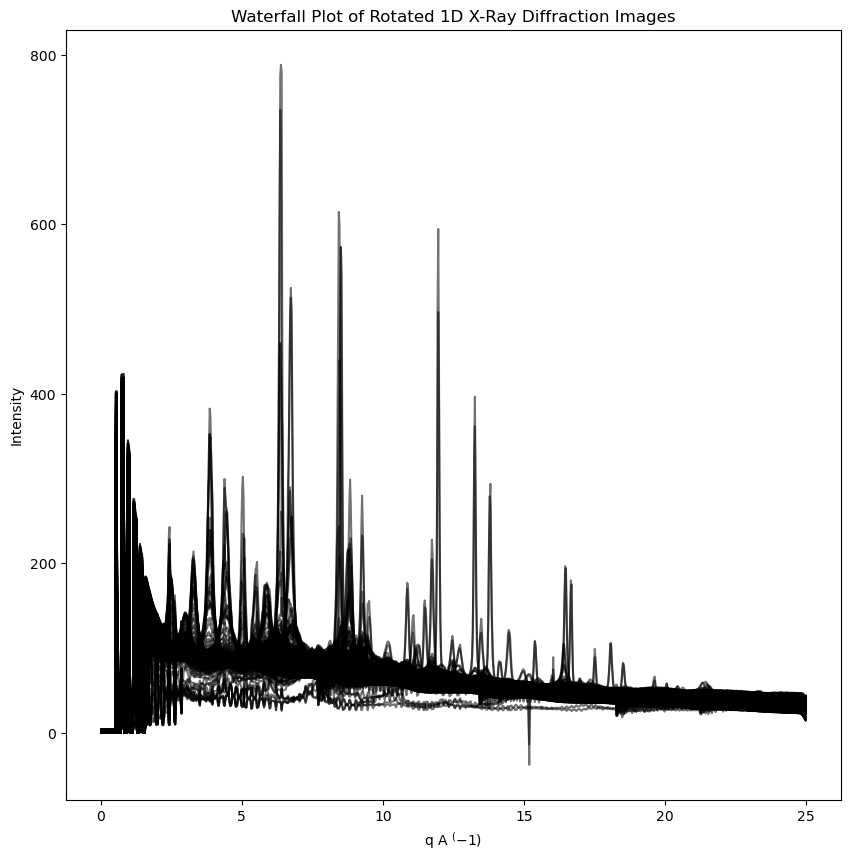

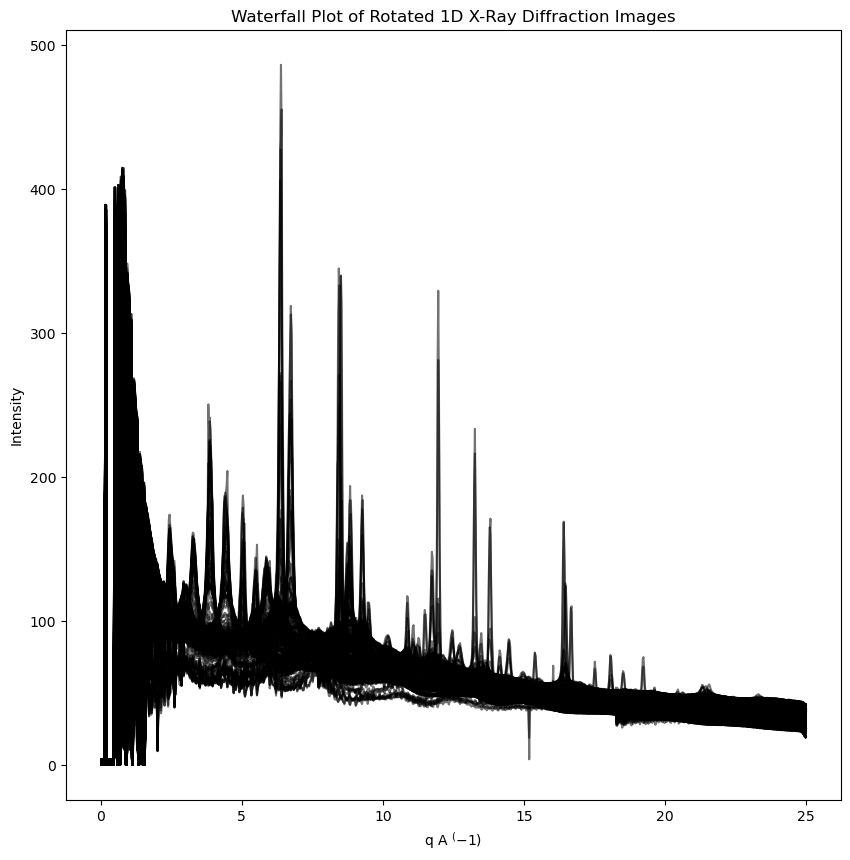

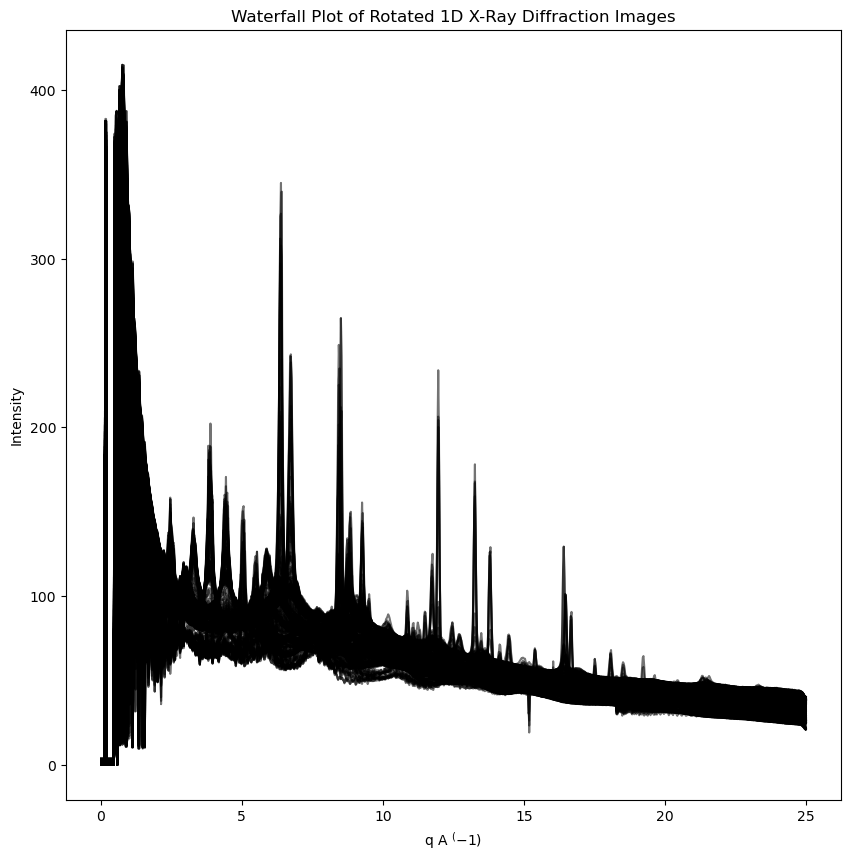

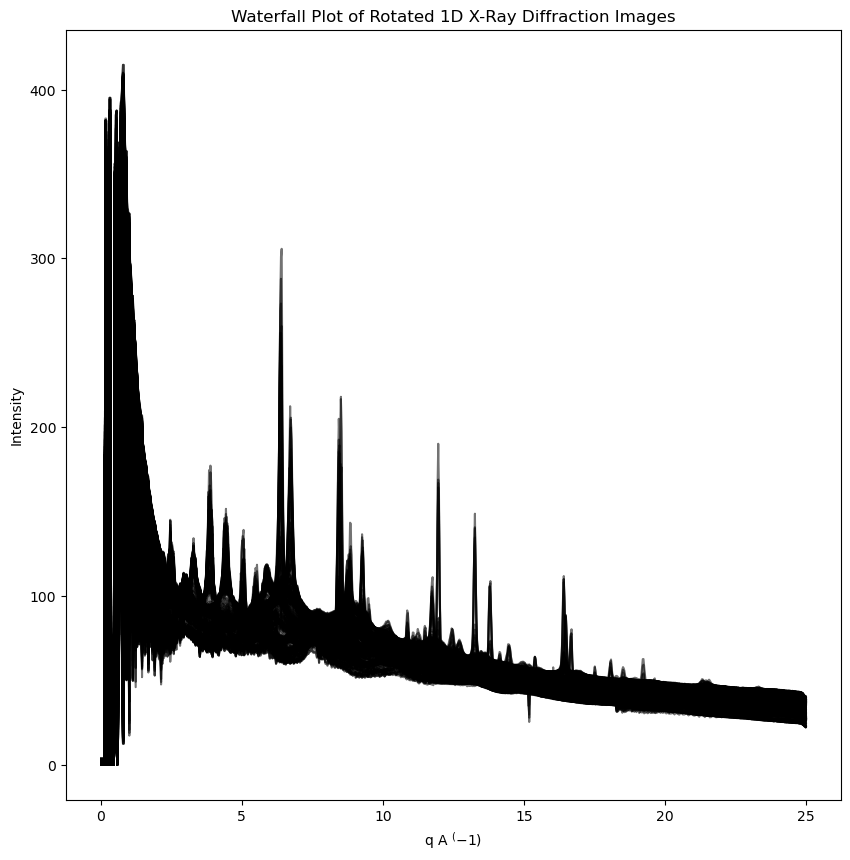

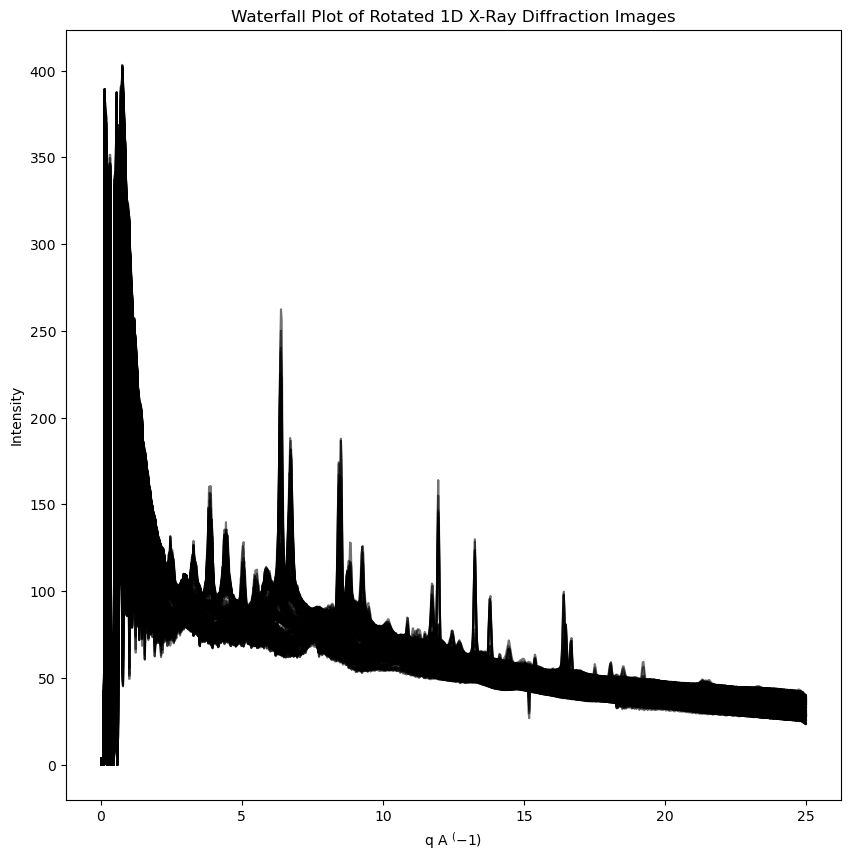

In [234]:
q, new_ints = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_one)
q, new_ints1 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_two)
q, new_ints2 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_three)
q, new_ints3 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_four)
q, new_ints4 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_five)

In [235]:
column_mapping = {}
for i in range(361, 721):
    column_mapping[(i - 361)] = (i)

new_ints1.rename(columns=column_mapping, inplace=True) 
   
column_mapping = {}
for i in range(722, 1082):
    column_mapping[(i - 722)] = (i)
print(column_mapping)

new_ints2.rename(columns=column_mapping, inplace=True) 
column_mapping = {}
for i in range(1083, 1443):
    column_mapping[(i - 1083)] = (i)
print(column_mapping)

new_ints3.rename(columns=column_mapping, inplace=True)    
column_mapping = {}
for i in range(1444, 1804):
    column_mapping[(i - 1444)] = (i)
    
new_ints4.rename(columns=column_mapping, inplace=True)  

{0: 722, 1: 723, 2: 724, 3: 725, 4: 726, 5: 727, 6: 728, 7: 729, 8: 730, 9: 731, 10: 732, 11: 733, 12: 734, 13: 735, 14: 736, 15: 737, 16: 738, 17: 739, 18: 740, 19: 741, 20: 742, 21: 743, 22: 744, 23: 745, 24: 746, 25: 747, 26: 748, 27: 749, 28: 750, 29: 751, 30: 752, 31: 753, 32: 754, 33: 755, 34: 756, 35: 757, 36: 758, 37: 759, 38: 760, 39: 761, 40: 762, 41: 763, 42: 764, 43: 765, 44: 766, 45: 767, 46: 768, 47: 769, 48: 770, 49: 771, 50: 772, 51: 773, 52: 774, 53: 775, 54: 776, 55: 777, 56: 778, 57: 779, 58: 780, 59: 781, 60: 782, 61: 783, 62: 784, 63: 785, 64: 786, 65: 787, 66: 788, 67: 789, 68: 790, 69: 791, 70: 792, 71: 793, 72: 794, 73: 795, 74: 796, 75: 797, 76: 798, 77: 799, 78: 800, 79: 801, 80: 802, 81: 803, 82: 804, 83: 805, 84: 806, 85: 807, 86: 808, 87: 809, 88: 810, 89: 811, 90: 812, 91: 813, 92: 814, 93: 815, 94: 816, 95: 817, 96: 818, 97: 819, 98: 820, 99: 821, 100: 822, 101: 823, 102: 824, 103: 825, 104: 826, 105: 827, 106: 828, 107: 829, 108: 830, 109: 831, 110: 832,

In [236]:
data_v = pd.concat([new_ints, new_ints1, new_ints2, new_ints3, new_ints4], axis = 1)
data_v

0          1          2          3          4          5     \
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
995  20.229408  20.154678  20.548010  20.885088  21.029493  20.690622   
996  19.122534  19.196341  19.135223  18.786898  19.137783  19.271702   
997  18.391266  18.442276  17.961840  16.730684  16.875252  17.537666   
998  17.633482  17.517813  16.394022  15.196261  15.188826  16.138767   
999  17.447857  16.262861  15.028953  14.268623  14.523180  14.630461   

          6          7          8          9     ...       1794       1795  \
0     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
..         ...        ...        ...        ...  ...        ...        ...   
995  20.935089  20.535126  20.301296  20.648470  ...  25.139008  25.145380   
996  19.277660  19.630487  19.387796  19.544188  ...  24.917788  24.877050   
997  18.401981  19.207369  18.919567  19.275963  ...  24.747152  24.806124   
998  17.400160  18.575422  18.561882  18.862619  ...  24.331022  24.479383   
999  15.340997  16.923262  17.357521  17.524364  ...  24.107204  24.187332   

          1796       1797       1798       1799       1800       1801  \
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
995  25.035482  24.917791  24.944490  24.860229  24.825010  24.776554   
996  24.848349  24.723526  24.657701  24.583530  24.436411  24.505945   
997  24.736084  24.663033  24.476044  24.080082  24.072582  24.109203   
998  24.558025  24.479782  24.233114  23.836794  23.754591  23.731037   
999  24.312847  24.205938  23.920843  23.797691  23.649311  23.634773   

          1802       1803  
0     0.000000   0.000000  
1     0.000000   0.000000  
2     0.000000   0.000000  
3     0.000000   0.000000  
4     0.000000   0.000000  
..         ...        ...  
995  24.563223  24.693117  
996  24.350327  24.502975  
997  24.185553  24.412615  
998  23.959930  24.207373  
999  23.712059  23.959225  

[1000 rows x 1800 columns]

          1056       732        1288       1088       877        1718  \
0     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
1     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
2     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
3     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
4     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
..         ...        ...        ...        ...        ...        ...   
995  27.376318  23.192772  28.406509  23.637686  29.349115  38.882046   
996  27.364660  22.646027  28.208733  23.400690  29.437307  38.393967   
997  27.469828  22.308149  28.000807  23.073421  29.547600  37.657352   
998  27.180498  21.586761  27.532080  22.663925  29.496231  36.900047   
999  27.172049  21.030241  26.921827  22.495300  29.534470  36.565517   

          1223       496        429        1489  ...       981        947   \
0     0.000000   0.000000   0.000000   0.0000

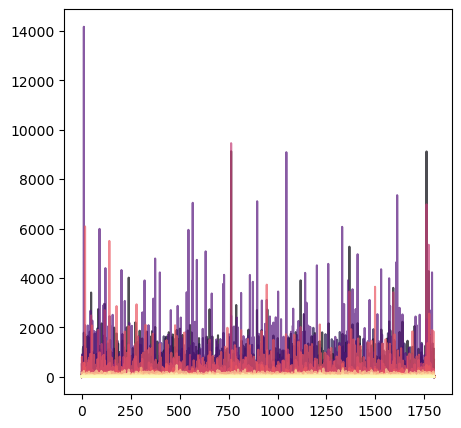

In [239]:
my_dict, my_comps = run_nmfac(data_v, clusters = 40)

cluster_groups = {}
for cluster_num in set(my_dict['Cluster_Number']):
    cluster_groups[cluster_num] = []

# Group the data based on cluster numbers
for cluster_num, int_angle in zip(my_dict['Cluster_Number'], my_dict['Int_Angle']):
    cluster_groups[cluster_num].append(int_angle)

In [238]:
data_v = data_v.clip(lower=0)

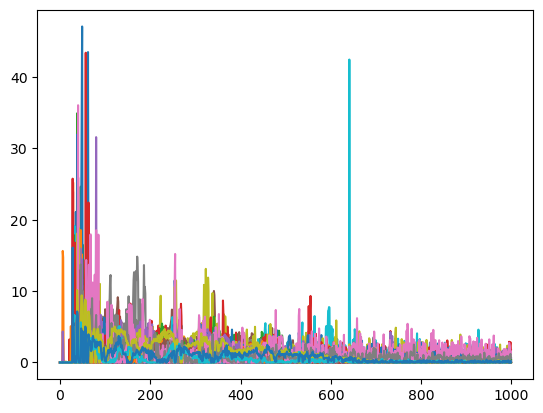

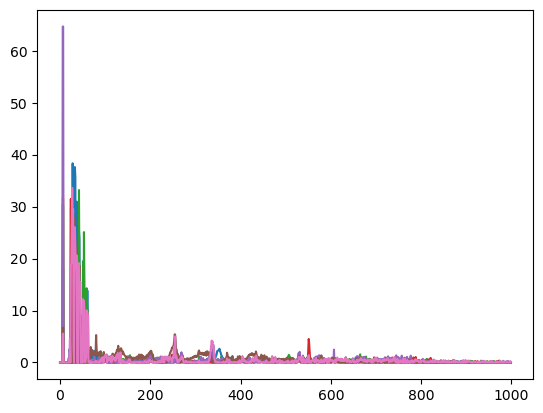

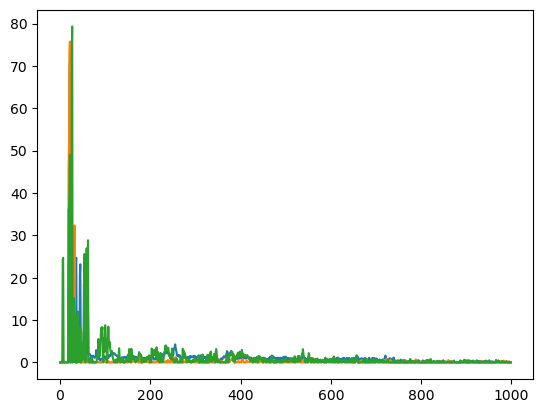

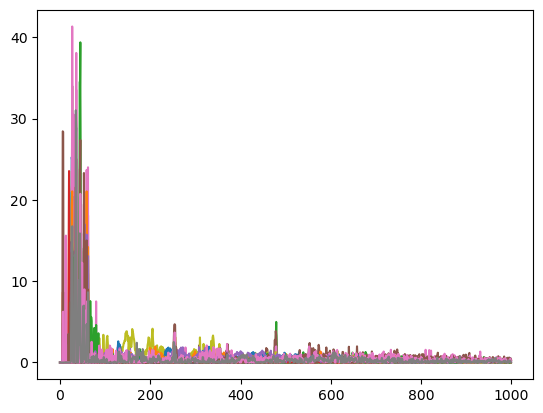

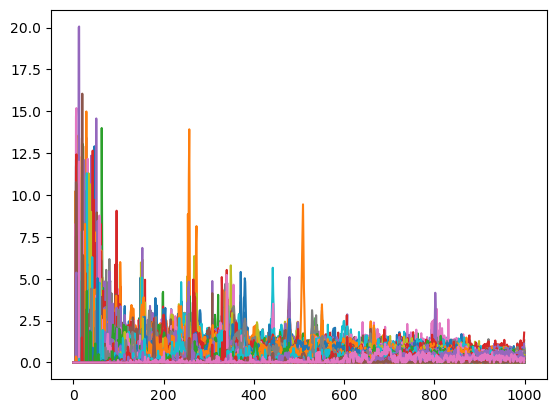

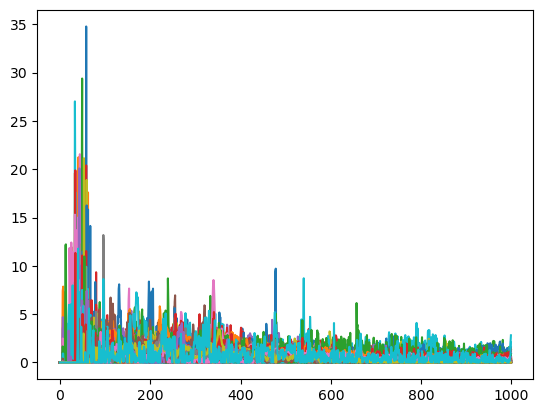

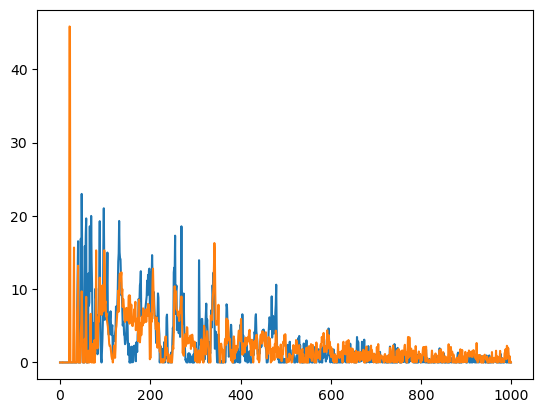

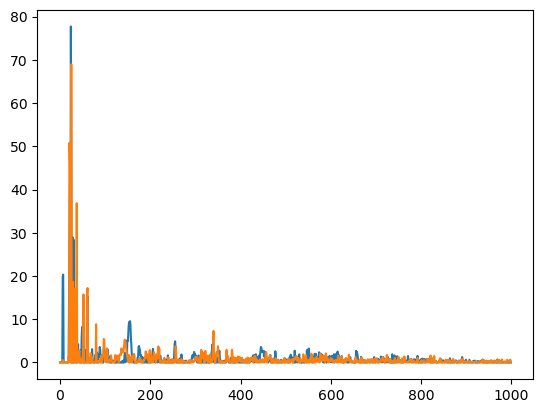

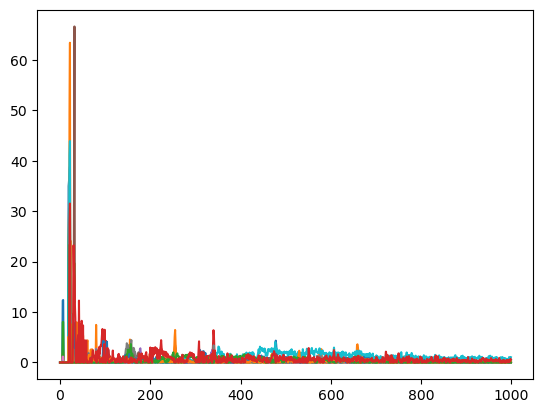

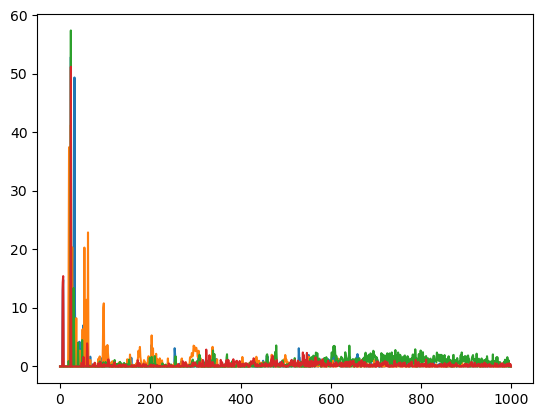

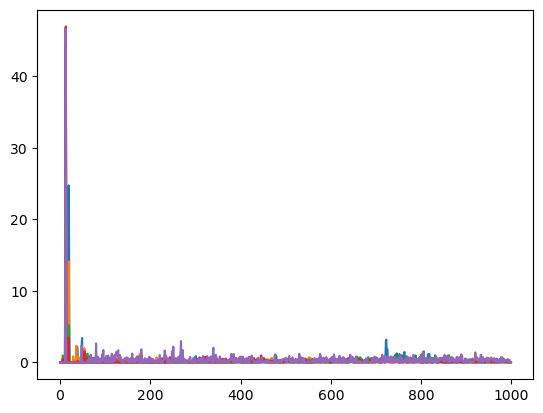

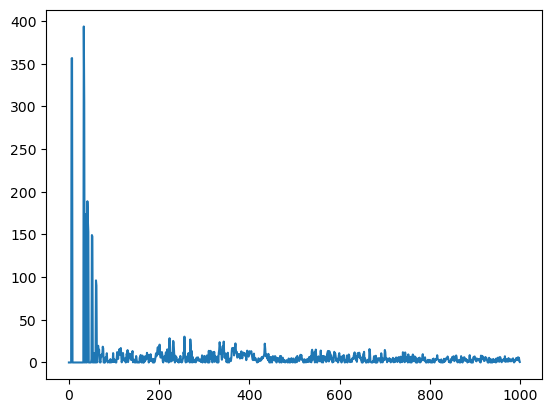

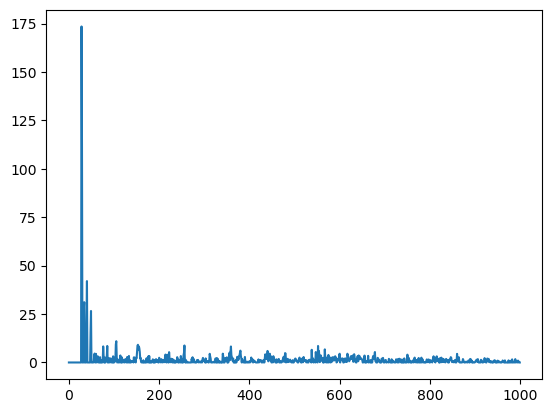

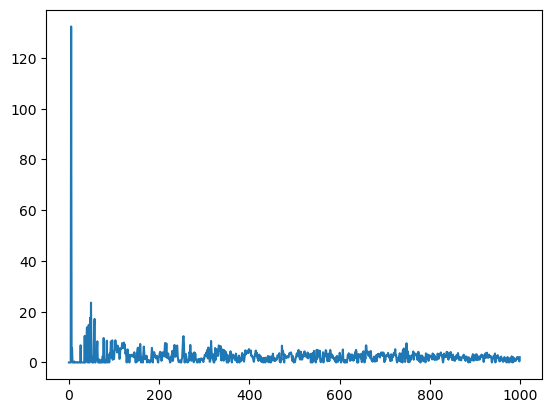

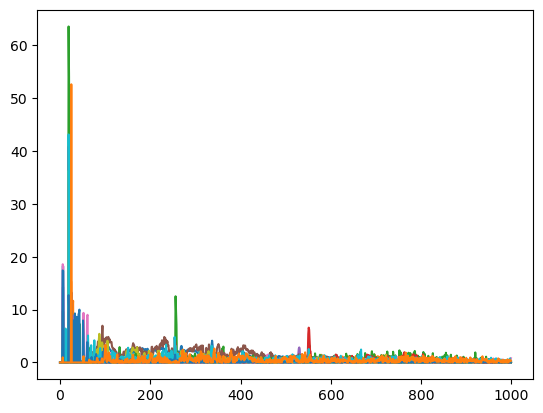

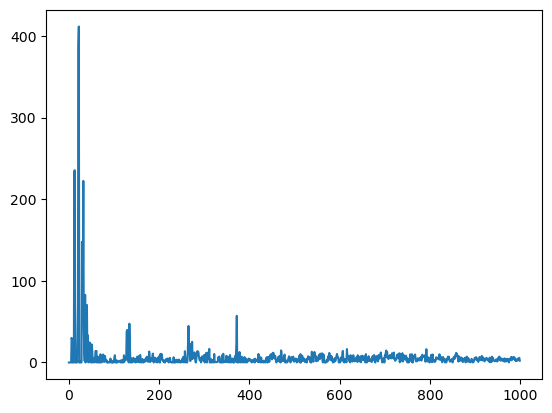

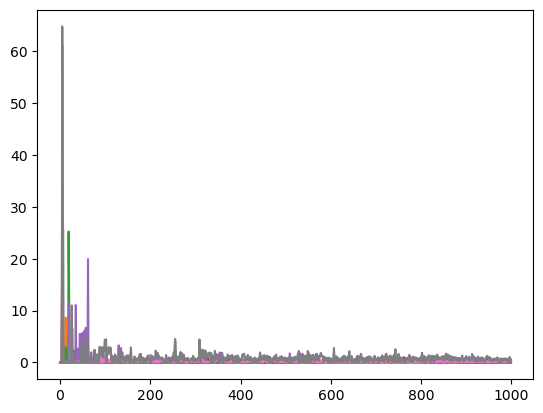

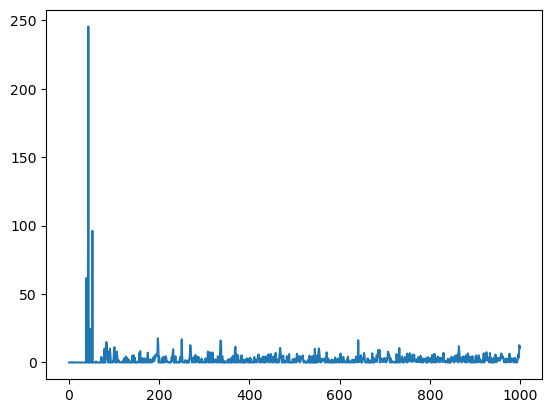

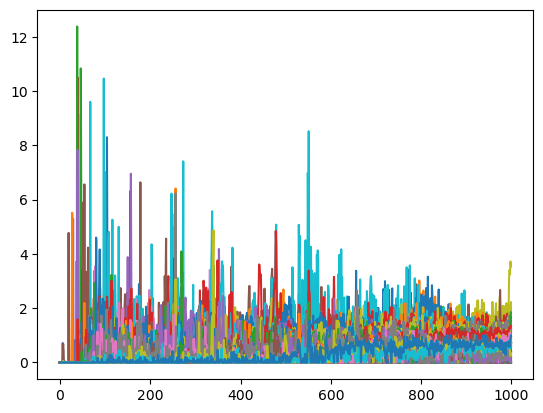

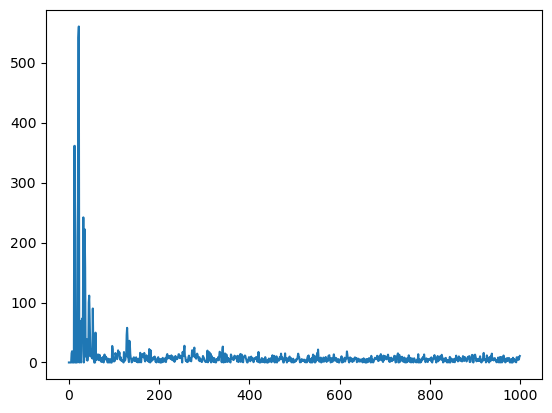

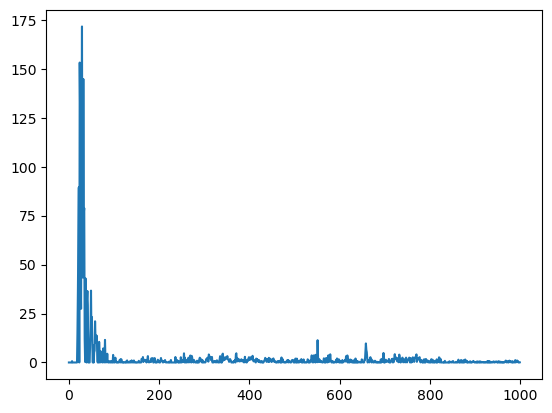

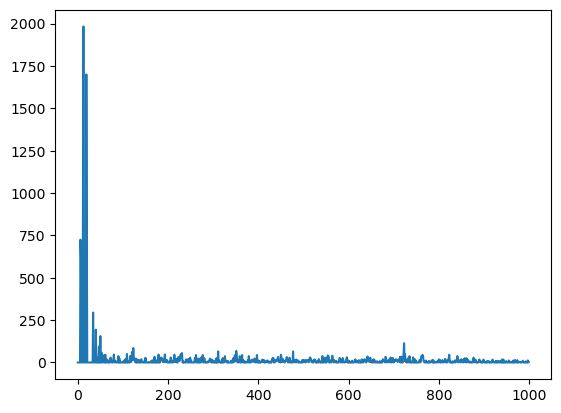

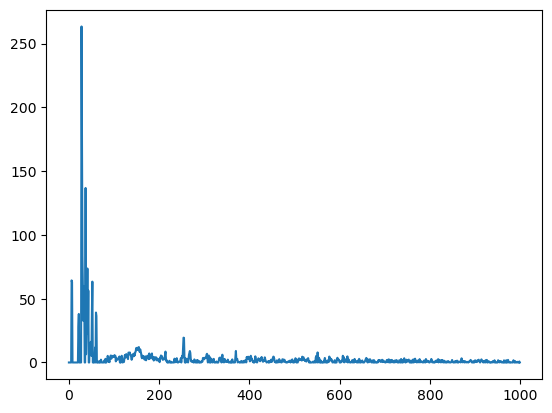

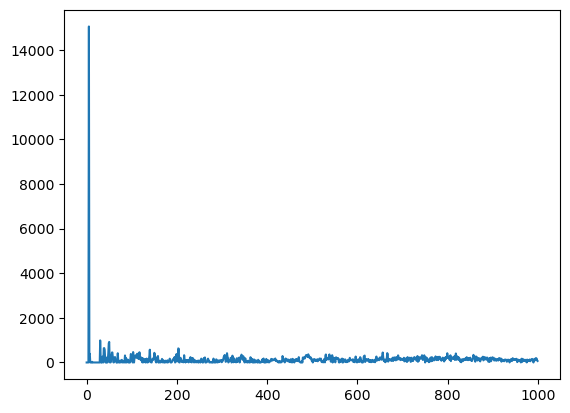

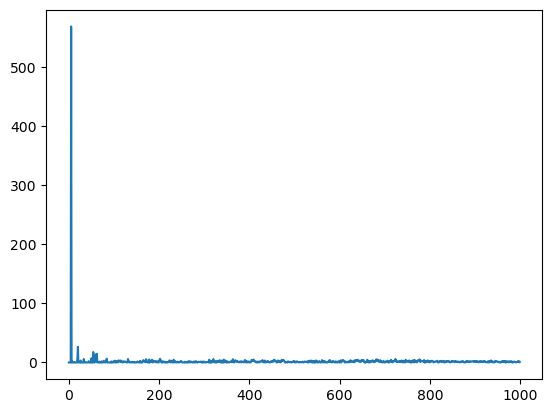

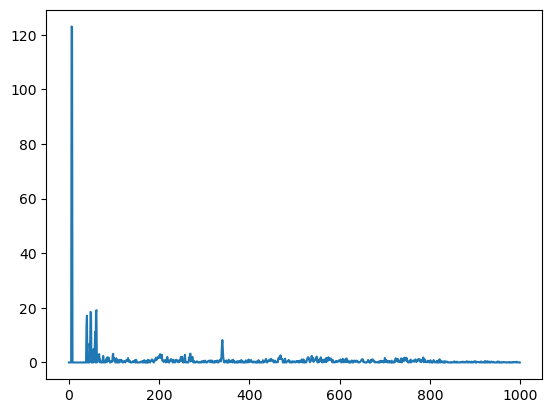

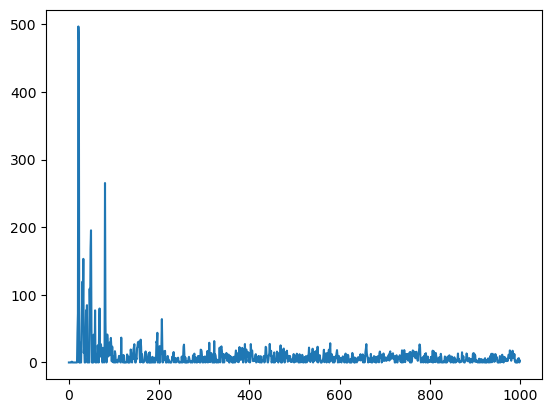

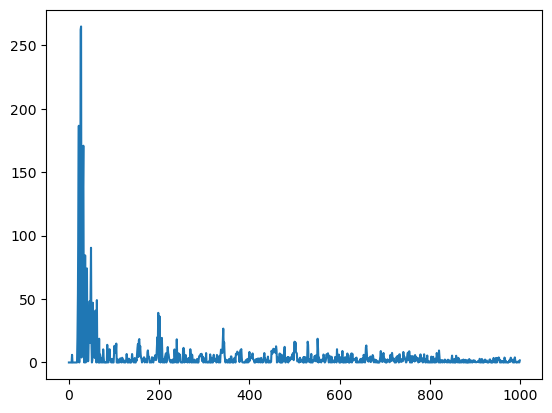

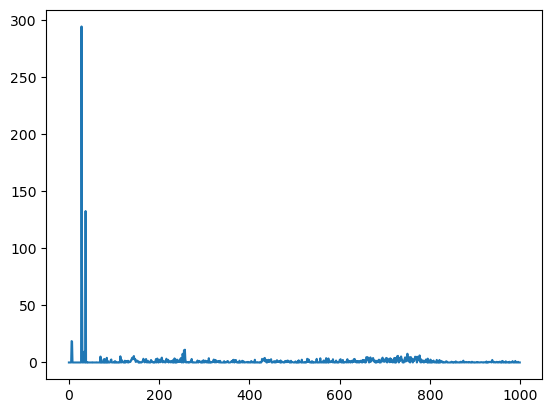

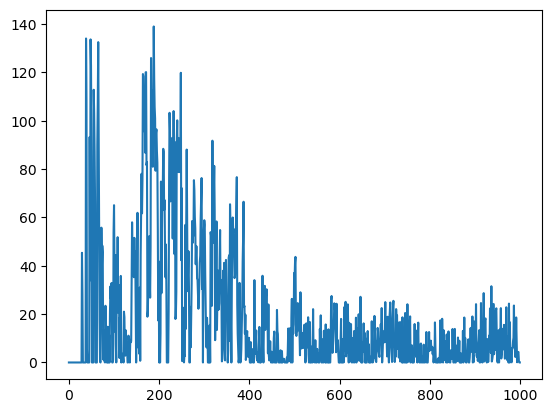

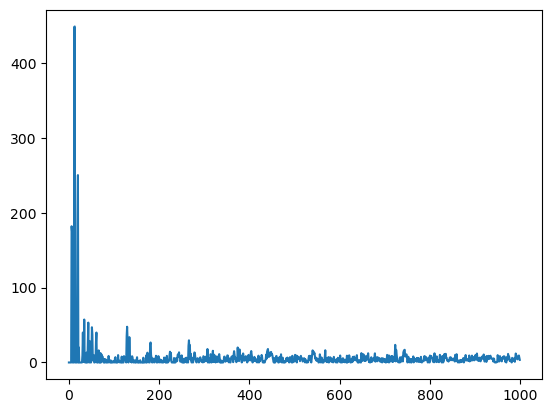

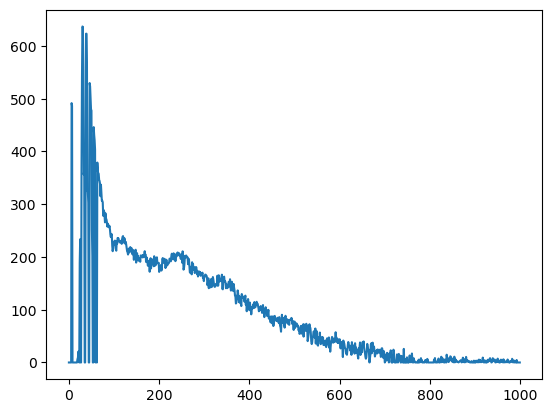

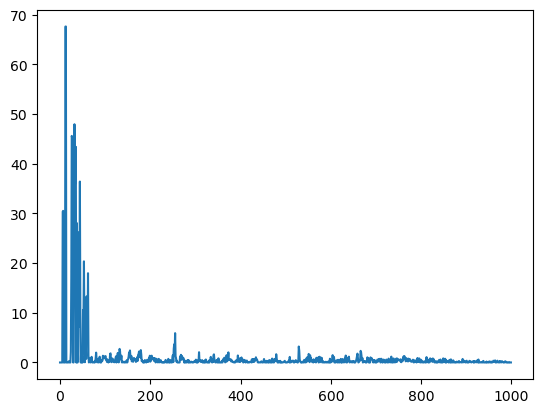

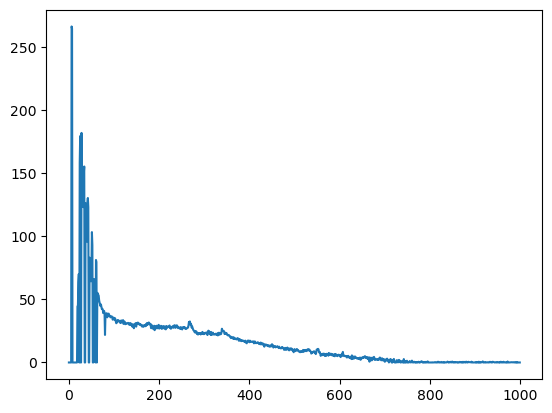

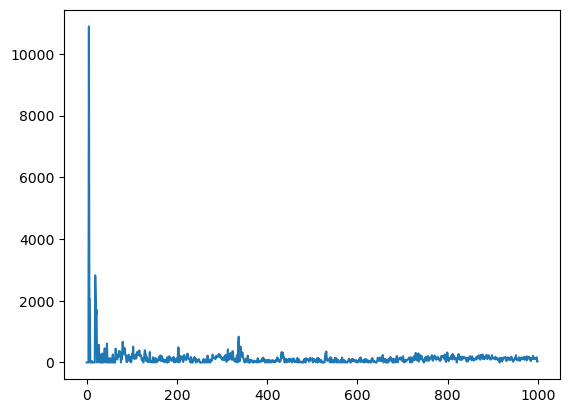

In [240]:
import matplotlib.pyplot as plt

for i in range(0, 35):
    plt.figure()
    for value in cluster_groups[i]:
        plt.plot(value)
    #plt.show()

Text(0.5, 1.0, 'VESTA GST Signal')

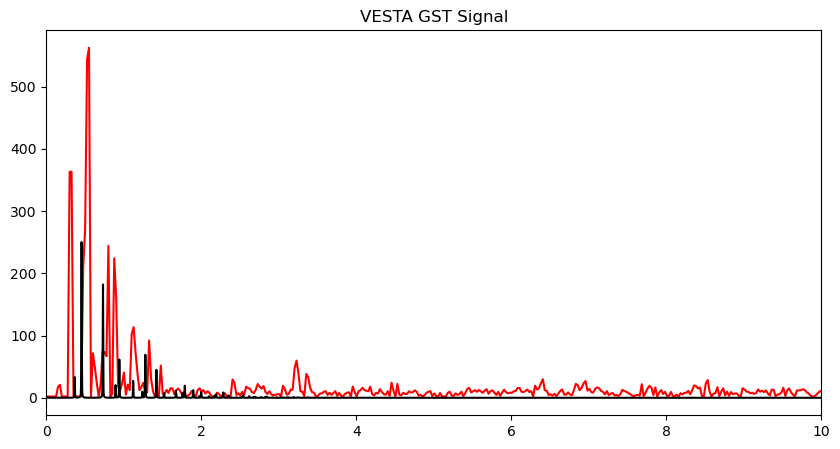

In [334]:
plt.figure(figsize = (10,5))
plt.plot(q_for_clusters,(cluster_groups[19][0])+2, c= 'r', label = 'Cluster 23')
plt.plot(q_for_vesta_new, vesta, label = 'VESTA GST Signal', c = 'k')

plt.xlim(0, 10)
plt.title('VESTA GST Signal')

In [242]:
q_for_clusters = np.linspace(0, 25, 1000)

Text(0.5, 1.0, 'VESTA GST Signal')

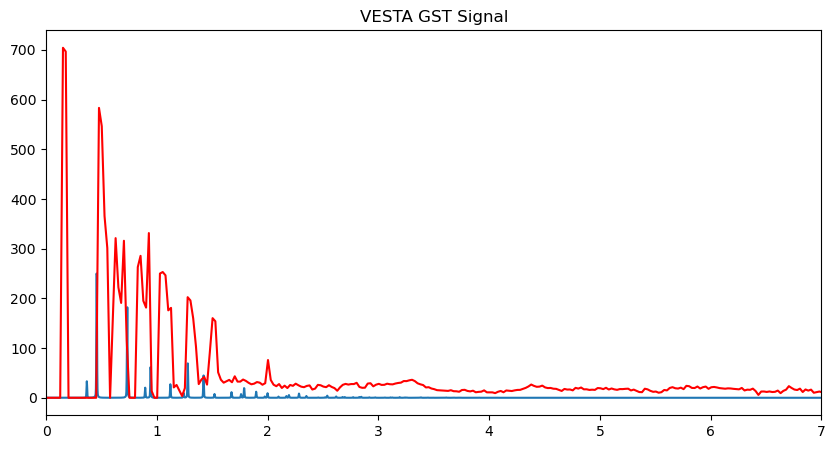

In [431]:
plt.figure(figsize = (10,5))
plt.plot(q_for_vesta_new, vesta)
plt.plot(q_for_clusters,(cluster_groups[35][0]*2), c= 'r', label = 'Cluster 23')
#plt.plot(q_for_clusters,(cluster_groups[19][0])+2, c= 'k', label = 'Cluster 23')
plt.xlim(0, 7)
plt.title('VESTA GST Signal')

In [432]:
avg = np.mean([cluster_groups[33][0] + cluster_groups[35][0]*.5 +cluster_groups[38][0]], axis = 0)

In [419]:
avg 

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.18706909e+02, 6.13135376e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.36082245e+02,
       3.18421936e+02, 2.46649719e+02, 2.20852249e+02, 0.00000000e+00,
       2.40258057e+02, 3.40245361e+02, 1.11122078e+02, 9.54086304e+01,
       3.40122620e+02, 2.25225540e+02, 1.87483536e+02, 1.93947540e+02,
       1.61447906e+02, 2.81246094e+02, 2.98283966e+02, 9.75460663e+01,
       9.06966324e+01, 2.92013214e+02, 1.45679626e+02, 1.36118301e+02,
       1.41357498e+02, 2.52186920e+02, 2.57025208e+02, 2.46413452e+02,
       8.79577255e+01, 9.04388275e+01, 1.16715607e+02, 1.21428513e+02,
       9.94542847e+01, 9.06901093e+01, 1.05309555e+02, 2.04636749e+02,
       1.90959778e+02, 7.99471817e+01, 5.17038078e+01, 9.57003174e+01,
      

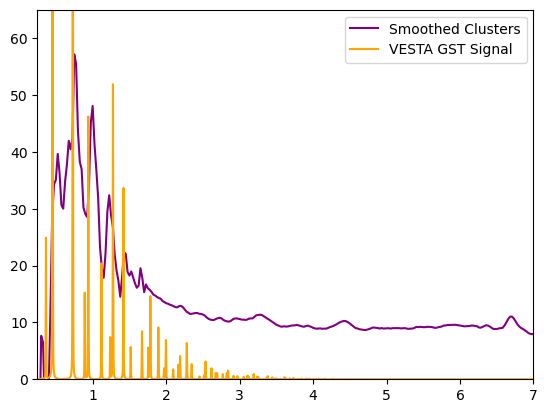

In [461]:
#avg = np.mean(cluster_groups[33][0] + cluster_groups[35][0], axis = 0)
smoothed_comp2 = scipy.signal.savgol_filter(avg , 16, 6)
plt.plot(q_for_clusters, smoothed_comp2*.25, c = 'purple', label = 'Smoothed Clusters')
plt.plot(q_for_vesta_new, vesta*.75, c = 'orange', label = 'VESTA GST Signal')
#plt.plot(q_for_fs, fs_data)
plt.xlim(0.25, 7)
plt.ylim(0,65)
plt.legend()

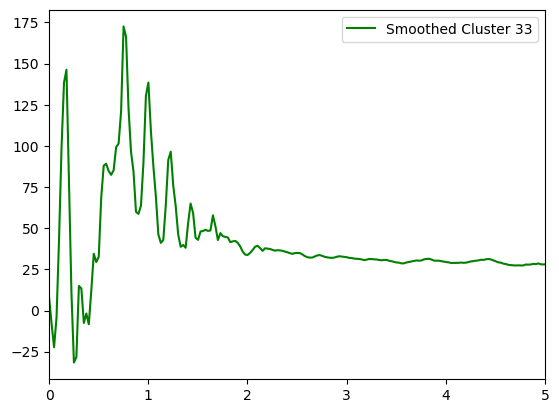

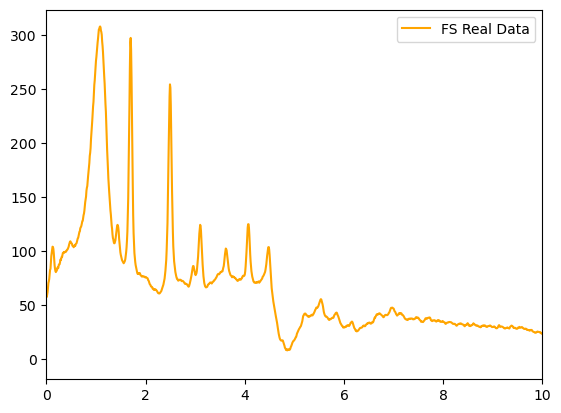

In [404]:
plt.figure()
plt.plot(q_for_clusters, smoothed_comp1, c = 'g', label = 'Smoothed Cluster 33')
plt.legend()
plt.xlim(0, 5)
plt.figure()
plt.plot(q_for_fs, fs_data, c = 'orange', label = 'FS Real Data')
plt.xlim(0, 10)
plt.legend()

(0.0, 200.0)

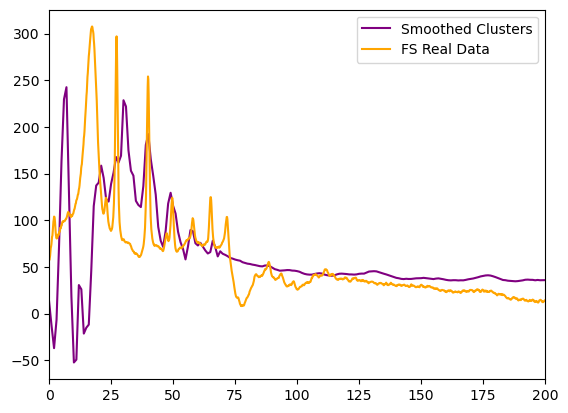

In [460]:
plt.plot(smoothed_comp2, c = 'purple', label = 'Smoothed Clusters')
plt.plot(x*.40,fs_data, c = 'orange', label = 'FS Real Data')
plt.legend()
plt.xlim(0,200)

In [443]:
x = np.linspace(0, 1000, 3000)

In [463]:
q, ints5 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_six)
q, ints6 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_seven)
q, ints7 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_eight)
q, ints8 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_nine)
q, ints9 = rotate_and_integrate(sc_img, 1, .254, .1667e-10, resolution = 1000, mask = mask_ten)